# Fake News Detection using Multi-Task Learning & BERT

**Notebook Structure:**

1.  **Library Imports:** Loading necessary libraries.
2.  **Centrally Defined Configuration & Parameters:** Setting up paths, hyperparameters, seeds, and device.
3.  **Utility Functions & Classes:** Definitions for:
    *   Data Loading & Preprocessing
    *   Exploratory Data Analysis (EDA)
    *   Functions & Classes for BERT & Multi-Task Learning Model
    *   Training
    *   Evaluation
4.  **Main Workflow:** Step-by-step execution:
    *   Loading Data
    *   Preprocessing & EDA
    *   Domain Classifier Training (ISOT vs. WELFake)
    *   Data Splitting
    *   Baseline Model (TF-IDF + Logistic Regression) 
    *   BERT & Multi-Task Learning (MTL) Setup
    *   MTL Model Training
    *   MTL Model Evaluation
    *   Results Summary

# Library Imports

The following code block contains all import statements to import all necessary Python libraries for the project. 

I group them by functionality (core data handling, machine learning, deep learning (PyTorch/Transformers), visualisation, and standard utility functions). Additionally, I also handle warning suppression and set a plot style.

In [58]:
# Library Imports

# core libraries
import os
import re
import string
import time
import warnings
import functools
import traceback

# data handling
import numpy as np
import pandas as pd
import random

# machine learning-related
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)

# deep learning-related
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (DistilBertForSequenceClassification, # Keep for potential single model use later?
                          DistilBertModel, # Used in MTL
                          DistilBertTokenizer, AdamW,
                          get_linear_schedule_with_warmup)
import torch.nn.functional as F

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
from tqdm import tqdm
from IPython.display import display

# configuration 
# warnings.filterwarnings("ignore") # Suppress simple warnings
sns.set_style('darkgrid') # Set default plot style

# for GUI
import gradio as gr
import lime
import lime.lime_text

# Centrally Defined Configuration & Parameters

The following code block centralises all configuration settings and hyperparameters for the project. 

This includes dataset paths, model parameters (e.g. BERT model name, sequence length, batch size, learning rate, epochs), the random seed for reproducibility, and device selection (GPU or CPU).

In [56]:
## Centrally Defined Configuration & Parameters

# dataset paths
ISOT_DATA_PATH = 'data/isot_dataset'
WELFAKE_DATA_PATH = 'data/welfake_dataset'
ISOT_TRUE_FILE = os.path.join(ISOT_DATA_PATH, 'True.csv')
ISOT_FAKE_FILE = os.path.join(ISOT_DATA_PATH, 'Fake.csv')
WELFAKE_FILE = os.path.join(WELFAKE_DATA_PATH, 'WELFake_Dataset.csv') 

# model configuration
BERT_MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 256   
BATCH_SIZE = 16   
LEARNING_RATE = 2e-5
EPOCHS_MTL = 3 

# training random seed 
SEED = 42 

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# device setup 
# use gpu if available, otherwise cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# output settings
# define paths for saving models or results if needed later
MODEL_CHECKPOINT_DIR = './model_checkpoints_mtl'
RESULTS_DIR = './results'
# create directories if they don't exist
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
# defining path for the best MTL model checkpoint
BEST_MTL_MODEL_PATH = os.path.join(MODEL_CHECKPOINT_DIR, 'mtl_model_best.bin')


# Utility Functions & Classes

## Data Loading & Preprocessing

The following code block contains functions dedicated to handling the datasets:

1.  **load_isot_dataset**: This function reads `True.csv` and `Fake.csv` from the ISOT dataset path, adds a 'label' column (1 for Real, 0 for Fake), adds a 'source' column, and combines them into a single Pandas DataFrame.

2.  **load_welfake_dataset**: This function reads `WELFake_Dataset.csv` from the WELFake dataset path, attempts to identify and standardize the 'label' column (ensuring 1 for Real, 0 for Fake), removes unnamed index columns, and adds a 'source' column. Includes error handling for missing files or columns.

3.  **combine_text**: This helper function concatenates 'title' and 'text' columns into a 'full_text' column and handles potential missing values (NaN).

4.  **clean_text**: This function performs basic text cleaning operations: converts text to lowercase, removes URLs, HTML tags, text in square brackets, punctuation (except apostrophes within words), numbers, and extra whitespace.

5.  **split_data**: This function splits a DataFrame into training, validation, and test sets using stratified sampling based on the 'label' column to maintain class distribution. Includes handling for cases where stratification might not be possible due to small class sizes.

In [8]:
# Data Loading & Preprocessing

# function to load isot dataset, combine true/fake news, and add labels/source
# arguments:
#   true_file_path - path to the CSV containing true news
#   fake_file_path - path to the CSV containing fake news
# returns:
#   pandas dataframe with combined isot data, or empty dataframe on error
def load_isot_dataset(true_file_path, fake_file_path):
    try:
        # step 1: read csv files
        df_true = pd.read_csv(true_file_path)
        df_fake = pd.read_csv(fake_file_path)

        # step 2: add label column (1 for real, 0 for fake)
        df_true['label'] = 1
        df_fake['label'] = 0

        # step 3: combine dataframes
        df_isot = pd.concat([df_true, df_fake], ignore_index=True)

        # step 4: add source column
        df_isot['source'] = 'ISOT'

        print(f"isot dataset: loaded {len(df_true)} true and {len(df_fake)} fake articles.")
        return df_isot
    except FileNotFoundError as e:
        print(f"error loading isot dataset: {e}. please check file paths.")
        return pd.DataFrame() # return empty dataframe on error
    except Exception as e: # catch other potential read errors
        print(f"an unexpected error occurred loading isot: {e}")
        return pd.DataFrame()



# function to load welfake dataset, standardise the label, and add source
# arguments:
#   file_path - path to the welfake CSV file
# returns:
#   pandas dataframe with welfake data, or empty dataframe on error
def load_welfake_dataset(file_path):
    try:
        # step 1: read csv file
        df_welfake = pd.read_csv(file_path)

        # step 2: remove potential unnamed index column
        if 'Unnamed: 0' in df_welfake.columns:
            df_welfake = df_welfake.drop(columns=['Unnamed: 0'])

        # step 3: standardise label column name (try 'Label' if 'label' not found, which idk why sometimes happens)
        if 'label' not in df_welfake.columns and 'Label' in df_welfake.columns:
             df_welfake = df_welfake.rename(columns={'Label': 'label'})

        # step 4: check if label column exists
        if 'label' not in df_welfake.columns:
            print("error: 'label' column not found in welfake dataset. cannot proceed.")
            return pd.DataFrame()

        # step 5: ensure labels are integers 0 or 1 (welfake uses 1 for real, 0 for fake)
        try:
            df_welfake['label'] = df_welfake['label'].astype(int)
            # verify if labels are indeed 0 and 1
            if not df_welfake['label'].isin([0, 1]).all():
                 print("warning: 'label' column in welfake contains values other than 0 and 1. check data.")
        except ValueError:
             print("error: could not convert 'label' column in welfake to integer. check data.")
             return pd.DataFrame()

        # step 6: add source column
        df_welfake['source'] = 'WELFake'

        print(f"welfake dataset: loaded {len(df_welfake)} articles.")
        return df_welfake
    except FileNotFoundError as e:
        print(f"error loading welfake dataset: {e}. please check file path.")
        return pd.DataFrame()
    except Exception as e: # catch other potential errors during loading/processing
        print(f"an unexpected error occurred loading welfake: {e}")
        return pd.DataFrame()



# function to combine title and text safely and handle potential NaN values
# arguments:
#   title - content of the title column
#   text - content of the text column
# returns:
#   combined string
def combine_text(title, text):
    # step 1: convert inputs to string, handling nan
    title_str = str(title) if pd.notna(title) else ''
    text_str = str(text) if pd.notna(text) else ''
    # step 2: add a space separator only if both parts exist
    separator = ' ' if title_str and text_str else ''
    # step 3: return concatenated string
    return title_str + separator + text_str



# function to perform basic text cleaning: lowercase, remove URLs, HTML, brackets,
# punctuation (keep internal apostrophes), numbers, extra whitespace.
# arguments:
#   text - input string
# returns:
#   cleaned string
def clean_text(text):
    # step 1: handle non-string input
    if not isinstance(text, str):
        return ''
    # step 2: convert to lowercase
    text = text.lower()
    # step 3: remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # step 4: remove urls
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # step 5: remove html tags
    text = re.sub(r'<.*?>+', '', text)
    # step 6: remove punctuation but keep apostrophes within words
    # temporarily replace internal apostrophes to preserve them
    text = re.sub(r"(\w)'(\w)", r"\1@@APOS@@\2", text)
    # remove all punctuation characters
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    # restore internal apostrophes
    text = text.replace("@@APOS@@", "'")
    # step 7: remove numbers
    text = re.sub(r'\d+', '', text)
    # step 8: remove extra whitespace and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text



# function to split dataframe into train, validation, and test sets with stratification
# arguments:
#   df - dataframe to split
#   test_size - proportion for test set (default 0.2)
#   val_size_of_train - proportion of training set to use for validation (default 0.1)
#   stratify_col - column name to stratify on (default 'label')
#   random_state - seed for reproducibility
# returns:
#   train_df, val_df, test_df as pandas dataframes
def split_data(df, test_size=0.2, val_size_of_train=0.1, stratify_col='label', random_state=SEED):
    # step 1: validate input dataframe and stratify column
    if df.empty or stratify_col not in df.columns:
        print(f"cannot split empty dataframe or missing stratify column '{stratify_col}'.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # step 2: check if stratification is possible for the first split
    counts = df[stratify_col].value_counts()
    if (counts < 2).any():
        print(f"warning: some classes in '{stratify_col}' have < 2 samples. stratification might fail. trying without.")
        stratify_values = None
    else:
        stratify_values = df[stratify_col]

    # step 3: split into train+validation and test
    try:
        train_val_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state,
            stratify=stratify_values
        )
    except ValueError as e:
         print(f"stratified split failed: {e}. splitting without stratification.")
         train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # step 4: calculate adjusted validation size for the second split
    val_size_adjusted = val_size_of_train / (1 - test_size)

    # step 5: check if stratification is possible for the second split
    stratify_train_val = None
    if stratify_values is not None: # only try if first stratification worked
        train_val_counts = train_val_df[stratify_col].value_counts()
        if not (train_val_counts < 2).any():
             stratify_train_val = train_val_df[stratify_col]
        else:
             print(f"warning: stratification for train/val split might fail (classes < 2).")

    # step 6: split train+validation into train and validation
    try:
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            random_state=random_state,
            stratify=stratify_train_val
        )
    except ValueError as e:
         print(f"stratified train/val split failed: {e}. splitting without stratification.")
         train_df, val_df = train_test_split(train_val_df, test_size=val_size_adjusted, random_state=random_state)

    print(f"dataset split sizes: train={len(train_df)}, validation={len(val_df)}, test={len(test_df)}")
    return train_df, val_df, test_df
    

## Exploratory Data Analysis

The following code block contains functions specifically for Exploratory Data Analysis:

1.  **generate_word_cloud**: This function creates and displays a word cloud visualisation from the text content of a given DataFrame, filtered by a specific label (e.g., Fake or Real news) and dataset source. It helps visualise the most frequent words in different categories.

In [10]:
# function to generate a word cloud visualisation for text based on label
# arguments:
#   df - dataframe containing 'cleaned_text' and 'label'
#   label_val - the label value to filter by (0 or 1)
#   label_name - string name for the label (e.g., 'Fake', 'Real')
#   source_name - string name for the data source (e.g., 'ISOT', 'WELFake')
# returns:
#   None (displays plot)
def generate_word_cloud(df, label_val, label_name, source_name):
    # step 1: filter data for the specified label and source
    text_series = df.loc[df['label'] == label_val, 'cleaned_text']
    if text_series.empty:
        print(f"no text found for {label_name} news in {source_name}.")
        return
    text = ' '.join(text_series)
    if not text.strip(): # check if the joined text is empty or just whitespace
         print(f"joined text is empty for {label_name} news in {source_name} after filtering.")
         return

    # step 2: generate wordcloud object
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              # consider adding stopwords='english' if needed, or max_words=100
                             ).generate(text)
    except ValueError as e:
         print(f"could not generate word cloud for {label_name} in {source_name} (likely empty text after filtering stopwords): {e}")
         return

    # step 3: display the plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label_name} News ({source_name})')
    plt.show()

## Functions & Classes for BERT & Multi-Task Learning Model

The following code block defines components related to the BERT and Multi-Task Learning (MTL) model:

1.  **NewsDataset (Class)**: This custom PyTorch `Dataset` class takes texts and labels, tokenises the text using the provided BERT tokeniser (padding/truncating to `MAX_LEN`), and returns formatted dictionaries containing `input_ids`, `attention_mask`, and `labels` as PyTorch tensors, ready for input into a BERT model.

2.  **create_dataset**: This helper function instantiates the `NewsDataset` from a DataFrame.

3.  **create_data_loader**: This helper function creates PyTorch `DataLoader` instances from `NewsDataset` objects, which handle batching and shuffling of data during training and evaluation.

4.  **DistilBertMTL (Class)**: This class defines the Multi-Task Learning model architecture. It uses a shared `DistilBertModel` base and adds two separate linear classification heads (`head_A` and `head_B`), one for each task (ISOT and WELFake). The `forward` method directs the input through the shared base and then selects the appropriate head based on a `task_id` argument. Includes dropout for regularisation.

In [12]:
## Functions & Classes for BERT & Multi-Task Learning Model

# this class formats the data correctly for BERT input. it takes texts and labels,
# tokenises the text using the provided BERT tokeniser (padding/truncating to max_len),
# and returns formatted dictionaries containing input_ids, attention_mask, and labels
# as PyTorch tensors.
class NewsDataset(Dataset):
    # constructor
    # arguments:
    #   texts - list or series of text strings
    #   labels - list or series of labels (0 or 1)
    #   tokenizer - the bert tokenizer instance
    #   max_len - maximum sequence length for padding/truncation
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    # function to get item count
    # returns: integer length of the dataset
    def __len__(self):
        return len(self.texts)

    # function to get an item (tokenised text and label) by index
    # arguments:
    #   item - index of the item to retrieve
    # returns:
    #   dictionary with tokenised 'input_ids', 'attention_mask', and 'labels' tensor
    def __getitem__(self, item):
        # step 1: get text and label for the item
        text = str(self.texts[item]) # ensure text is string
        label = self.labels[item]

        # step 2: tokenise text using the provided tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,    # add '[CLS]' and '[SEP]'
            max_length=self.max_len,    # pad & truncate
            padding='max_length',       # pad to max_length
            truncation=True,            # truncate to max_length
            return_attention_mask=True, # create attention masks
            return_tensors='pt',        # return PyTorch tensors
        )

        # step 3: format output dictionary
        return {
            # 'text': text, # optionally keep original text for debugging
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



# helper function to create a NewsDataset object from a dataframe
# arguments:
#   df - dataframe containing 'cleaned_text' and 'label' columns
#   tokenizer - the bert tokenizer instance
#   max_len - maximum sequence length
# returns:
#   NewsDataset object or None if df is empty/invalid
def create_dataset(df, tokenizer, max_len):
    # step 1: validate input dataframe
    if df is None or df.empty:
        print("warning: dataframe is none or empty, cannot create dataset.")
        return None
    if 'cleaned_text' not in df.columns or 'label' not in df.columns:
         print("error: missing 'cleaned_text' or 'label' column in dataframe.")
         return None

    # step 2: reset index for safe access by integer index in __getitem__
    df = df.reset_index(drop=True)

    # step 3: instantiate and return the dataset object
    return NewsDataset(
        texts=df['cleaned_text'].tolist(),
        labels=df['label'].tolist(),
        tokenizer=tokenizer,
        max_len=max_len
    )



# helper function to create a DataLoader instance from a NewsDataset object
# arguments:
#   ds - NewsDataset object
#   batch_size - batch size for the dataloader
#   num_workers - number of worker processes for loading data (default 0)
#   shuffle - whether to shuffle data (True for train, False for val/test)
# returns:
#   DataLoader object or None if dataset is None
def create_data_loader(ds, batch_size, num_workers=0, shuffle=False):
    # step 1: validate input dataset
    if ds is None:
        print("warning: dataset is none, cannot create dataloader.")
        return None
    # step 2: instantiate and return the dataloader object
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers, # set higher (e.g., 2 or 4) if cpu allows for faster loading
        shuffle=shuffle
    )



# the DistilBertMTL class defines the DistilBERT MTL architecture. It uses a shared DistilBERT base
# and adds two separate linear classification heads (head_A, head_B) for each task.
# this also includes dropout for regularisation.
class DistilBertMTL(nn.Module):
    # constructor
    # arguments:
    #   bert_model_name - name of the pretrained distilbert model (default from config)
    def __init__(self, bert_model_name=BERT_MODEL_NAME):
        super(DistilBertMTL, self).__init__()
        # step 1: load shared bert base model (without the classification head)
        self.bert = DistilBertModel.from_pretrained(bert_model_name)

        # step 2: define task-specific classification heads
        hidden_size = self.bert.config.hidden_size # get hidden dimension from bert config

        # head for task a (e.g., isot) - maps hidden size to 2 output classes (fake/real)
        self.head_A = nn.Linear(hidden_size, 2)

        # head for task b (e.g., welfake) - maps hidden size to 2 output classes
        self.head_B = nn.Linear(hidden_size, 2)

        # step 3: define dropout layer for regularisation during classification
        # use dropout rate from distilbert config for consistency
        self.dropout = nn.Dropout(self.bert.config.seq_classif_dropout)

    # forward pass function for the mtl model. directs input through the shared base
    # and selects the appropriate head based on task_id.
    # arguments:
    #   input_ids - token ids tensor from tokenizer
    #   attention_mask - attention mask tensor from tokenizer
    #   task_id - identifier for the task ('A' or 'B') specifying which head to use
    # returns:
    #   logits tensor from the specified task head
    def forward(self, input_ids, attention_mask, task_id):
        # step 1: pass input through the shared bert base
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # step 2: get the pooled output (hidden state corresponding to the [CLS] token)
        # shape: (batch_size, hidden_size)
        pooled_output = outputs.last_hidden_state[:, 0, :]

        # step 3: apply dropout to the pooled output
        pooled_output = self.dropout(pooled_output)

        # step 4: pass the pooled output through the appropriate task-specific head
        if task_id == 'A':
            logits = self.head_A(pooled_output)
        elif task_id == 'B':
            logits = self.head_B(pooled_output)
        else:
            # raise error for invalid task id
            raise ValueError("invalid task_id provided. must be 'A' or 'B'.")

        return logits


## Training 

The following code block defines the core function for training the models:

1.  **train_epoch_mtl**: This function performs one epoch of training for the `DistilBertMTL` model. It interleaves batches from the two task-specific DataLoaders (Task A and Task B). For each batch, it performs a forward pass using the correct `task_id`, calculates the loss, performs a backward pass to update weights (affecting both the specific head and the shared BERT base), and updates the optimizer and learning rate scheduler. It tracks and returns the average loss and accuracy across all batches in the epoch.

In [14]:
## Training

# function for one mtl training epoch, interleaving batches from two loaders.
# performs forward/backward passes, updates weights, and tracks metrics.
# arguments:
#   model - the pytorch mtl model to train
#   loader_A - dataloader for task a training data (e.g., isot)
#   loader_B - dataloader for task b training data (e.g., welfake)
#   loss_fn - the loss function (e.g., crossentropyloss)
#   optimizer - the optimizer (e.g., adamw)
#   device - the device to run on ('cuda' or 'cpu')
#   scheduler - learning rate scheduler
# returns:
#   tuple: (average training loss for the epoch, average training accuracy for the epoch)
def train_epoch_mtl(model, loader_A, loader_B, loss_fn, optimizer, device, scheduler, epoch_num, total_epochs):
    # step 1: set model to training mode
    model = model.train()

    # step 2: setup iterators and batch tracking
    iter_A = iter(loader_A)
    iter_B = iter(loader_B)
    len_A = len(loader_A)
    len_B = len(loader_B)
    total_batches = len_A + len_B # total number of batches to process in one epoch

    # step 3: initialise metrics tracking for the epoch
    total_loss = 0
    total_correct_predictions = 0
    total_samples = 0
    start_time = time.time()

    # step 4: loop through combined batches from both loaders
    pbar = tqdm(range(total_batches), desc=f'Epoch {epoch_num}/{total_epochs} Training', leave=True)
    
    for i in pbar:
        # determine which loader to use for the current batch
        # simple alternation strategy: try to alternate, take from A first if equal chance
        
        use_loader_A = (i % 2 == 0 and (i // 2) < len_A) or ((i // 2) >= len_B and (i - len_B) < len_A)

        # get batch and corresponding task id
        try:
            if use_loader_A:
                task_id = 'A'
                batch = next(iter_A)
            else:
                task_id = 'B'
                batch = next(iter_B)
        except StopIteration:
            # safeguard against potential StopIteration errors
            print(f"\nwarning: stopiteration caught unexpectedly at batch {i+1}/{total_batches}.")
            continue
        except Exception as e_batch: 
             break # Exit loop on error
        
        # move batch data to the designated device 
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # perform one training step 
        optimizer.zero_grad() # zero gradients before forward pass

        # forward pass through model, specifying the task id
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            task_id=task_id
        )

        # calculate loss using the appropriate head's output
        loss = loss_fn(logits, labels)

        # backward pass to compute gradients
        loss.backward()

        # apply gradient clipping to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # update model weights
        optimizer.step()

        # update learning rate based on scheduler
        scheduler.step()

        # track performance metrics for the batch
        _, preds = torch.max(logits, dim=1)
        correct_batch_preds = torch.sum(preds == labels).item()
        total_loss += loss.item()
        total_correct_predictions += correct_batch_preds
        total_samples += labels.size(0)

        # update tqdm postfix with current average loss/accuracy 
        # Calculate metrics *so far* within the epoch
        current_avg_loss = total_loss / (i + 1)
        current_avg_acc = total_correct_predictions / total_samples if total_samples > 0 else 0
        pbar.set_postfix(loss=f'{current_avg_loss:.4f}', acc=f'{current_avg_acc:.4f}')


    print() # add a newline after the epoch progress indicator finishes

    # step 5: calculate average loss and accuracy for the entire epoch
    avg_loss = total_loss / total_batches if total_batches > 0 else 0
    avg_accuracy = total_correct_predictions / total_samples if total_samples > 0 else 0

    return avg_loss, avg_accuracy


## Evaluation

The following code block defines the core functions for evaluating the models:

1.  **eval_model_mtl**: This function evaluates the `DistilBertMTL` model on a given DataLoader for a *specific task* (`task_id`). It sets the model to evaluation mode (`model.eval()`), disables gradient calculations (`torch.no_grad()`), iterates through the data, performs forward passes using the specified `task_id`, and calculates loss, accuracy, precision, recall, F1-score, and ROC AUC. It returns a dictionary containing these metrics along with predictions and probabilities.

2.  **evaluate_predictions**: This function takes true labels, predicted labels, and predicted probabilities (for the positive class) as input, along with model/dataset names. It calculates and prints standard classification metrics (Accuracy, Precision, Recall, F1, ROC AUC) and displays a Classification Report, Confusion Matrix plot, and ROC Curve plot. It returns a dictionary of the calculated scalar metrics. This function is used for generating final reports for both baseline and MTL models.

In [16]:
# function for evaluating the mtl model on validation/test data for a specific task.
# disables gradients, performs forward pass using task_id, calculates metrics.
# arguments:
#   model - the pytorch mtl model to evaluate
#   data_loader - dataloader for the evaluation data (validation or test)
#   task_id - identifier for the task being evaluated ('A' or 'B')
#   loss_fn - the loss function
#   device - the device to run on
# returns:
#   dictionary containing evaluation metrics ('loss', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc',
#   'predictions', 'probabilities', 'true_labels') for the specified task, or None if evaluation fails.
def eval_model_mtl(model, data_loader, task_id, loss_fn, device):
    # step 1: validate dataloader input
    if data_loader is None:
        print(f"skipping evaluation for task {task_id}: dataloader is none.")
        return None

    # step 2: set model to evaluation mode (disables dropout, etc.)
    model = model.eval()

    # step 3: initialise lists to store results from all batches
    losses = []
    all_preds = []
    all_labels = []
    all_probs = [] # probabilities for the positive class (label 1)

    # step 4: evaluation loop without gradient calculations
    with torch.no_grad():
        for d in data_loader:
            # move batch data to device
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # forward pass - MUST specify task_id for correct head
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_id=task_id
            )

            # calculate loss
            loss = loss_fn(logits, labels)
            losses.append(loss.item())

            # get predictions and probabilities
            _, preds = torch.max(logits, dim=1)
            # calculate probability of the positive class (class 1)
            probs = torch.softmax(logits, dim=1)[:, 1]

            # store batch results (move tensors to cpu before converting to numpy)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # step 5: check if any samples were processed
    if not all_labels:
        print(f"no samples found for evaluation task {task_id}.")
        return None

    # step 6: calculate overall metrics using stored results
    avg_loss = np.mean(losses)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    try:
         # calculate roc auc using probabilities of the positive class
         roc_auc = roc_auc_score(all_labels, all_probs)
    except ValueError as e:
         # handle cases where only one class is present in y_true (cannot calculate roc auc)
         print(f"could not calculate roc-auc for task {task_id} during eval: {e}. setting to 0.0")
         roc_auc = 0.0

    # step 7: compile results into a dictionary
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_preds, # include raw predictions if needed elsewhere
        'probabilities': all_probs, # include probabilities for roc curve
        'true_labels': all_labels # include true labels for consistency
    }

    return metrics

# function to evaluate prediction results, calculate metrics, print report, and generate plots
# arguments:
#   y_true - numpy array of true labels
#   y_pred - numpy array of predicted labels
#   y_proba - numpy array of predicted probabilities for the positive class (class 1)
#   model_name - string name of the model (e.g., "Baseline", "MTL Model")
#   dataset_name - string name of the dataset (e.g., "ISOT Test", "WELFake Test")
# returns:
#   dictionary of scalar metrics ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
def evaluate_predictions(y_true, y_pred, y_proba, model_name, dataset_name):
    # step 1: validate inputs to prevent errors with empty arrays
    if y_true is None or y_pred is None or y_proba is None or len(y_true) == 0:
        print(f"skipping evaluation for {model_name} on {dataset_name}: missing or empty data arrays.")
        return None

    print(f"\nevaluating {model_name} on {dataset_name}")

    # step 2: calculate standard classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        # calculate roc auc using probabilities of the positive class
        roc_auc = roc_auc_score(y_true, y_proba)
    except ValueError as e:
        # handle cases where roc auc cannot be calculated (e.g., only one class present)
        print(f"could not calculate roc-auc for {model_name} on {dataset_name}: {e}. setting to 0.0")
        roc_auc = 0.0

    # step 3: print metrics and detailed classification report
    print(f"  accuracy:  {accuracy:.4f}")
    print(f"  precision: {precision:.4f}")
    print(f"  recall:    {recall:.4f}")
    print(f"  f1-score:  {f1:.4f}")
    print(f"  roc-auc:   {roc_auc:.4f}")
    print("\n  classification report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))

    # step 4: generate and display confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
    plt.title(f'Confusion Matrix: {model_name} on {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # optionally save the plot
    # plt.savefig(os.path.join(RESULTS_DIR, f'cm_{model_name.replace(" ", "_")}_{dataset_name.replace(" ", "_")}.png'))
    plt.show()

    # step 5: generate and display roc curve plot
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # plot diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name} on {dataset_name}')
    plt.legend(loc="lower right")
    # optionally save the plot
    # plt.savefig(os.path.join(RESULTS_DIR, f'roc_{model_name.replace(" ", "_")}_{dataset_name.replace(" ", "_")}.png'))
    plt.show()

    # step 6: return calculated scalar metrics in a dictionary
    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc
    }


# Main Workflow

The following section is dedicated to the execution of the main steps of the project by calling the functions defined above.

## 1. Load Datasets

The following code block will load both ISOT and WELFake datasets, and display some basic information relating to the datasets.

In [19]:
# load datasets
df_isot = load_isot_dataset(ISOT_TRUE_FILE, ISOT_FAKE_FILE)
df_welfake = load_welfake_dataset(WELFAKE_FILE)

# combine title and text into 'full_text'
if not df_isot.empty:
    # check if required columns exist
    if 'title' in df_isot.columns and 'text' in df_isot.columns:
        df_isot['full_text'] = df_isot.apply(lambda row: combine_text(row['title'], row['text']), axis=1)
        # keep only necessary columns + source
        df_isot = df_isot[['full_text', 'label', 'source']].copy()
        print("isot: combined 'title' and 'text' into 'full_text'.")
    else:
        print("warning: 'title' or 'text' column missing in isot df. cannot create 'full_text'.")
        # fallback: use only 'text' if available
        if 'text' in df_isot.columns:
             df_isot['full_text'] = df_isot['text'].fillna('').astype(str)
             df_isot = df_isot[['full_text', 'label', 'source']].copy()
             print("isot: used only 'text' column as 'full_text'.")
        else:
             print("error: neither 'title' nor 'text' found in isot df. cannot proceed with isot.")
             df_isot = pd.DataFrame() # make empty to prevent downstream errors


if not df_welfake.empty:
    # check if required columns exist
    if 'title' in df_welfake.columns and 'text' in df_welfake.columns:
        df_welfake['full_text'] = df_welfake.apply(lambda row: combine_text(row['title'], row['text']), axis=1)
        df_welfake = df_welfake[['full_text', 'label', 'source']].copy()
        print("welfake: combined 'title' and 'text' into 'full_text'.")
    else:
         print("warning: 'title' or 'text' column missing in welfake df. cannot create 'full_text'.")
         # fallback: use only 'text' if available
         if 'text' in df_welfake.columns:
             df_welfake['full_text'] = df_welfake['text'].fillna('').astype(str)
             df_welfake = df_welfake[['full_text', 'label', 'source']].copy()
             print("welfake: used only 'text' column as 'full_text'.")
         else:
             print("error: neither 'title' nor 'text' found in welfake df. cannot proceed with welfake.")
             df_welfake = pd.DataFrame() # make empty

# display basic info for loaded dataframes
print("\nisot dataset info")
if not df_isot.empty:
    df_isot.info()
    print("\nisot head:\n", df_isot.head())
    print("\nisot value counts (0=fake, 1=real):\n", df_isot['label'].value_counts())
    print("\nisot null values check:\n", df_isot.isnull().sum())
else:
    print("isot dataframe is empty or failed to load.")

print("\nwelfake dataset info")
if not df_welfake.empty:
    df_welfake.info()
    print("\nwelfake head:\n", df_welfake.head())
    print("\nwelfake value counts (0=fake, 1=real):\n", df_welfake['label'].value_counts())
    print("\nwelfake null values check:\n", df_welfake.isnull().sum())
else:
    print("welfake dataframe is empty or failed to load.")
    

isot dataset: loaded 21417 true and 23481 fake articles.
welfake dataset: loaded 72134 articles.
isot: combined 'title' and 'text' into 'full_text'.
welfake: combined 'title' and 'text' into 'full_text'.

isot dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  44898 non-null  object
 1   label      44898 non-null  int64 
 2   source     44898 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB

isot head:
                                            full_text  label source
0  As U.S. budget fight looms, Republicans flip t...      1   ISOT
1  U.S. military to accept transgender recruits o...      1   ISOT
2  Senior U.S. Republican senator: 'Let Mr. Muell...      1   ISOT
3  FBI Russia probe helped by Australian diplomat...      1   ISOT
4  Trump wants Postal Service to charge 'much mor...      1   ISOT

isot val

## 2. Data Preprocessing & EDA

The following code block applies further preprocessing and performs Exploratory Data Analysis:

1.  **Text Cleaning**: Applies the `clean_text` function to the `full_text` column of both DataFrames to create a `cleaned_text` column.

2.  **Text Length Analysis**: Calculates the length of the `cleaned_text` and plots histograms to visualise the distribution of text lengths for both datasets. Descriptive statistics for text lengths are also printed.

3.  **Word Clouds**: Generates word clouds for fake and real news within each dataset using the `generate_word_cloud` function. Note: This can be slow on large datasets.

4.  **Filtering & Deduplication**: Removes rows with very short or empty `cleaned_text` (e.g., <= 10 characters). Checks for and removes duplicate rows based on `cleaned_text` and `label` to avoid data leakage.

5.  **Final Balance Check**: Prints the normalised value counts for the 'label' column in each DataFrame after cleaning and filtering to show the final class distribution.

isot: applied clean_text.
welfake: applied clean_text.

analysing text lengths

ISOT cleaned text length stats:
 count    44898.000000
mean      2465.958283
std       2099.955401
min          0.000000
25%       1269.000000
50%       2195.000000
75%       3084.000000
max      50422.000000
Name: text_length, dtype: float64

WELFake cleaned text length stats:
 count     72134.000000
mean       3218.889081
std        3596.507038
min           0.000000
25%        1385.000000
50%        2409.000000
75%        3983.000000
max      138343.000000
Name: text_length, dtype: float64


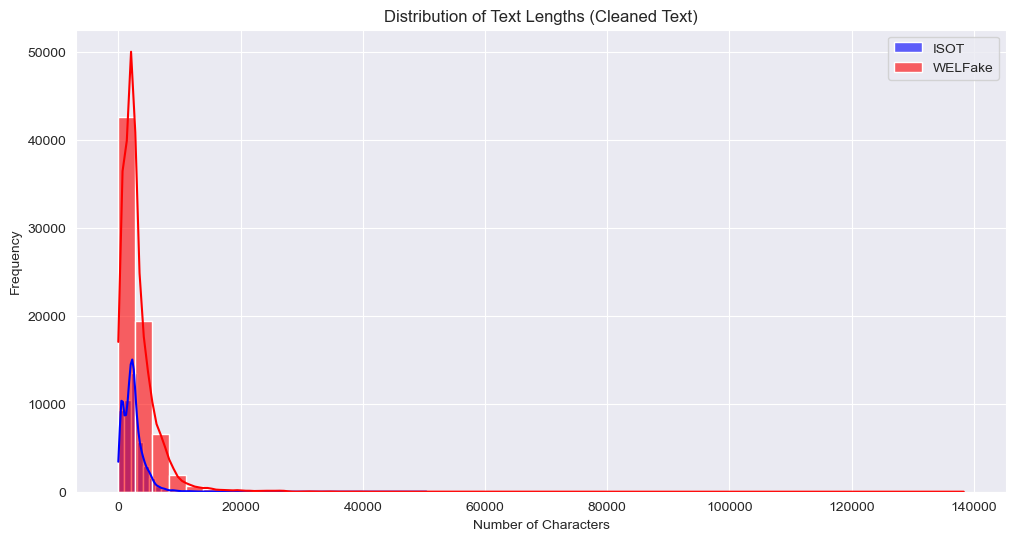

GENERATE_WORDCLOUDS set to False - not generating word clouds for EDA
isot: removed 10 articles with cleaned_text length <= 10.
isot: removed 5795 duplicate articles (based on cleaned_text & label).
isot: final shape after filtering/deduplication: (39093, 5)
welfake: removed 30 articles with cleaned_text length <= 10.
welfake: removed 8481 duplicate articles (based on cleaned_text & label).
welfake: final shape after filtering/deduplication: (63623, 5)

final data balance after preprocessing
isot label distribution:
 label
1    0.542143
0    0.457857
Name: proportion, dtype: float64

welfake label distribution:
 label
0    0.546783
1    0.453217
Name: proportion, dtype: float64


In [21]:
# apply basic cleaning to 'full_text'
if not df_isot.empty:
    df_isot['cleaned_text'] = df_isot['full_text'].apply(clean_text)
    print("isot: applied clean_text.")
if not df_welfake.empty:
    df_welfake['cleaned_text'] = df_welfake['full_text'].apply(clean_text)
    print("welfake: applied clean_text.")

# analyse text lengths of cleaned text
print("\nanalysing text lengths")
if not df_isot.empty:
    df_isot['text_length'] = df_isot['cleaned_text'].apply(len)
if not df_welfake.empty:
    df_welfake['text_length'] = df_welfake['cleaned_text'].apply(len)

# plot histograms of text lengths
plt.figure(figsize=(12, 6))
plot_lengths = False # flag to check if anything was plotted
if not df_isot.empty:
    sns.histplot(data=df_isot, x='text_length', bins=50, kde=True, label='ISOT', color='blue', alpha=0.6)
    print("\nISOT cleaned text length stats:\n", df_isot['text_length'].describe())
    plot_lengths = True
if not df_welfake.empty:
    sns.histplot(data=df_welfake, x='text_length', bins=50, kde=True, label='WELFake', color='red', alpha=0.6)
    print("\nWELFake cleaned text length stats:\n", df_welfake['text_length'].describe())
    plot_lengths = True

if plot_lengths:
    plt.title('Distribution of Text Lengths (Cleaned Text)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
else:
    print("no data available to plot text length distributions.")


# word clouds

# set to true to generate word clouds (kinda time-consuming and I didn't actually learn anything from it)
GENERATE_WORDCLOUDS = False 

if GENERATE_WORDCLOUDS:
    print("\ngenerating word clouds")
    # i might consider sampling if datasets are very large: df.sample(n=10000, random_state=SEED)
    if not df_isot.empty:
        print("generating isot word clouds...")
        generate_word_cloud(df_isot, 0, 'Fake', 'ISOT')
        generate_word_cloud(df_isot, 1, 'Real', 'ISOT')
    else:
        print("skipping isot word clouds (dataframe empty).")

    if not df_welfake.empty:
        print("generating welfake word clouds...")
        generate_word_cloud(df_welfake, 0, 'Fake', 'WELFake')
        generate_word_cloud(df_welfake, 1, 'Real', 'WELFake')
    else:
        print("skipping welfake word clouds (dataframe empty).")
else:
    print("GENERATE_WORDCLOUDS set to False - not generating word clouds for EDA")


# filter short/empty texts, drop duplicates
min_text_length = 10 # minimum number of characters required for cleaned text

if not df_isot.empty:
    initial_len = len(df_isot)
    # filter based on cleaned text length
    df_isot = df_isot[df_isot['cleaned_text'].str.len() > min_text_length].copy()
    print(f"isot: removed {initial_len - len(df_isot)} articles with cleaned_text length <= {min_text_length}.")
    # drop duplicates based on cleaned text and label
    initial_len = len(df_isot)
    df_isot = df_isot.drop_duplicates(subset=['cleaned_text', 'label'], keep='first')
    print(f"isot: removed {initial_len - len(df_isot)} duplicate articles (based on cleaned_text & label).")
    print(f"isot: final shape after filtering/deduplication: {df_isot.shape}")

if not df_welfake.empty:
    initial_len = len(df_welfake)
    # filter based on cleaned text length
    df_welfake = df_welfake[df_welfake['cleaned_text'].str.len() > min_text_length].copy()
    print(f"welfake: removed {initial_len - len(df_welfake)} articles with cleaned_text length <= {min_text_length}.")
    # drop duplicates based on cleaned text and label
    initial_len = len(df_welfake)
    df_welfake = df_welfake.drop_duplicates(subset=['cleaned_text', 'label'], keep='first')
    print(f"welfake: removed {initial_len - len(df_welfake)} duplicate articles (based on cleaned_text & label).")
    print(f"welfake: final shape after filtering/deduplication: {df_welfake.shape}")

# final checks on data balance after prepreocessing
print("\nfinal data balance after preprocessing")
if not df_isot.empty:
    print("isot label distribution:\n", df_isot['label'].value_counts(normalize=True))
else:
    print("isot dataframe is empty.")
if not df_welfake.empty:
    print("\nwelfake label distribution:\n", df_welfake['label'].value_counts(normalize=True))
else:
    print("welfake dataframe is empty.")


## 3. Domain Classifier Training (ISOT vs WELFake)

The following code block trains a simple auxiliary classifier. Its purpose is to predict whether a given piece of cleaned text is more stylistically similar to the articles found in the ISOT dataset or the WELFake dataset. This domain prediction will be used later in the GUI to select the most appropriate specialized head from the main MTL model for Fake/Real classification.

1.  **Data Preparation**: Combines `cleaned_text` from `df_isot` and `df_welfake`, creating a `domain_label` (0 for ISOT, 1 for WELFake).

2.  **Splitting**: Splits this combined data for training and testing the domain classifier.

3.  **TF-IDF Vectorisation**: Fits a `TfidfVectorizer` specifically for the domain classification task.

4.  **Logistic Regression Training**: Trains a `LogisticRegression` model (`domain_classifier`) to predict the `domain_label`.

5.  **Evaluation**: Briefly evaluates the accuracy and classification report of the trained domain classifier on its test set.

In [23]:
# domain classifier training

print("\ntraining domain classifier (tf-idf + logistic regression)")

domain_vectorizer = None
domain_classifier = None
df_domain_data = pd.DataFrame() # initialize empty dataframe

# prepare data for domain classification
if not df_isot.empty and 'cleaned_text' in df_isot.columns and \
   not df_welfake.empty and 'cleaned_text' in df_welfake.columns:

    print("preparing data for domain classification...")
    # select relevant columns and add domain label
    df_isot_domain = df_isot[['cleaned_text']].copy()
    df_isot_domain['domain_label'] = 0 # 0 for ISOT

    df_welfake_domain = df_welfake[['cleaned_text']].copy()
    df_welfake_domain['domain_label'] = 1 # 1 for WELFake

    # combine data
    df_domain_data = pd.concat([df_isot_domain, df_welfake_domain], ignore_index=True)
    # shuffle combined data
    df_domain_data = df_domain_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
    print(f"combined domain dataset size: {len(df_domain_data)}")
    print("domain label distribution:\n", df_domain_data['domain_label'].value_counts(normalize=True))

    # split data for domain classifier training/evaluation
    print("splitting domain data...")
    try:
        domain_train_df, domain_test_df = train_test_split(
            df_domain_data,
            test_size=0.2, # use 20% for testing the domain classifier
            random_state=SEED,
            stratify=df_domain_data['domain_label']
        )
        print(f"domain split sizes: train={len(domain_train_df)}, test={len(domain_test_df)}")

        # train tf-idf vectoriser for domain
        print("initialising and fitting domain tf-idf vectoriser...")
        domain_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 1)) # simpler vectorizer worked best here
        X_domain_train_tfidf = domain_vectorizer.fit_transform(domain_train_df['cleaned_text'])
        y_domain_train = domain_train_df['domain_label']
        print(f"domain tf-idf training matrix shape: {X_domain_train_tfidf.shape}")

        # train logistic regression classifier for domain
        print("training domain logistic regression classifier...")
        domain_classifier = LogisticRegression(solver='liblinear', random_state=SEED, max_iter=1000)
        domain_classifier.fit(X_domain_train_tfidf, y_domain_train)
        print("domain classifier trained.")

        # evaluate domain classifier
        print("\nevaluating domain classifier performance...")
        X_domain_test_tfidf = domain_vectorizer.transform(domain_test_df['cleaned_text'])
        y_domain_test = domain_test_df['domain_label']
        domain_pred_test = domain_classifier.predict(X_domain_test_tfidf)
        domain_acc = accuracy_score(y_domain_test, domain_pred_test)
        print(f"  domain classifier test accuracy: {domain_acc:.4f}")
        print("  domain classifier classification report:\n",
              classification_report(y_domain_test, domain_pred_test, target_names=['ISOT (0)', 'WELFake (1)'], digits=4))

    except Exception as e_domain:
        print(f"an error occurred during domain classifier training/evaluation: {e_domain}")
        domain_vectorizer = None
        domain_classifier = None

else:
    print("skipping domain classifier training: cleaned isot or welfake dataframes are missing/empty.")



training domain classifier (tf-idf + logistic regression)
preparing data for domain classification...
combined domain dataset size: 102716
domain label distribution:
 domain_label
1    0.619407
0    0.380593
Name: proportion, dtype: float64
splitting domain data...
domain split sizes: train=82172, test=20544
initialising and fitting domain tf-idf vectoriser...
domain tf-idf training matrix shape: (82172, 5000)
training domain logistic regression classifier...
domain classifier trained.

evaluating domain classifier performance...
  domain classifier test accuracy: 0.5631
  domain classifier classification report:
               precision    recall  f1-score   support

    ISOT (0)     0.3911    0.2654    0.3162      7819
 WELFake (1)     0.6230    0.7461    0.6790     12725

    accuracy                         0.5631     20544
   macro avg     0.5071    0.5057    0.4976     20544
weighted avg     0.5348    0.5631    0.5409     20544



## 4. Data Splitting

The following code block splits the processed ISOT and WELFake DataFrames into training, validation, and test sets using the `split_data` function.

Stratification is used to ensure similar label distributions across the splits. It also creates a combined training set (`df_combined_train`) by concatenating the training sets from both datasets, which is primarily used for training the baseline model, and shuffles it.

In [25]:
print("\nsplitting data into train/validation/test sets")

# perform splits for each dataset using the split_data function
print("splitting isot dataset...")
df_isot_train, df_isot_val, df_isot_test = split_data(df_isot, test_size=0.2, val_size_of_train=0.1, random_state=SEED)

print("\nsplitting welfake dataset...")
df_welfake_train, df_welfake_val, df_welfake_test = split_data(df_welfake, test_size=0.2, val_size_of_train=0.1, random_state=SEED)

# create combined training set (for baseline model)
print("\ncreating combined training set (for baseline)")
# combine only if both individual training sets were successfully created
if not df_isot_train.empty and not df_welfake_train.empty:
    df_combined_train = pd.concat([df_isot_train, df_welfake_train], ignore_index=True)
    print("combined isot and welfake training sets.")
elif not df_isot_train.empty:
    print("using only isot for combined training (welfake train split missing/empty).")
    df_combined_train = df_isot_train.copy()
elif not df_welfake_train.empty:
    print("using only welfake for combined training (isot train split missing/empty).")
    df_combined_train = df_welfake_train.copy()
else:
    print("error: both isot and welfake training sets are empty. cannot create combined set.")
    df_combined_train = pd.DataFrame()

# shuffle the combined training data if it was created
if not df_combined_train.empty:
    df_combined_train = df_combined_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
    print(f"combined training set size: {len(df_combined_train)}")
    print("combined training set label distribution:\n", df_combined_train['label'].value_counts(normalize=True))

print("\ncreating combined test set...")
# combine only if both individual test sets were successfully created
if not df_isot_test.empty and not df_welfake_test.empty:
    df_combined_test = pd.concat([df_isot_test, df_welfake_test], ignore_index=True)
    print(f"combined test set created. size: {len(df_combined_test)}")
    # no shuffling needed for test set
elif not df_isot_test.empty:
    print("using only isot for combined test (welfake test split missing/empty).")
    df_combined_test = df_isot_test.copy()
    print(f"combined test set created (isot only). size: {len(df_combined_test)}")
elif not df_welfake_test.empty:
    print("using only welfake for combined test (isot test split missing/empty).")
    df_combined_test = df_welfake_test.copy()
    print(f"combined test set created (welfake only). size: {len(df_combined_test)}")
else:
    print("warning: both isot and welfake test sets are empty. cannot create combined test set.")
    df_combined_test = pd.DataFrame()

print("\ndata splitting complete.")


splitting data into train/validation/test sets
splitting isot dataset...
dataset split sizes: train=27364, validation=3910, test=7819

splitting welfake dataset...
dataset split sizes: train=44535, validation=6363, test=12725

creating combined training set (for baseline)
combined isot and welfake training sets.
combined training set size: 71899
combined training set label distribution:
 label
0    0.512942
1    0.487058
Name: proportion, dtype: float64

creating combined test set...
combined test set created. size: 20544

data splitting complete.


## 5. Baseline Model: TF-IDF + Logistic Regression

The following code block implements and evaluates a simple baseline model:

1.  **TF-IDF Vectorisation**: Initialises a `TfidfVectorizer` (with English stop words, max features, and n-gram range) and fits it *only* on the `df_combined_train` data. It then transforms the combined training data and *both* test sets (ISOT and WELFake) into TF-IDF feature matrices.

2.  **Logistic Regression Training**: Initialises and trains a `LogisticRegression` model using the TF-IDF features from the combined training set and corresponding labels.

3.  **Baseline Evaluation**: Evaluates the trained baseline model separately on the ISOT test set and the WELFake test set using the `evaluate_predictions` function, which calculates metrics and generates plots (Confusion Matrix, ROC Curve). The results (scalar metrics) are stored.


baseline model (tf-idf + logistic regression):
initialising tf-idf vectoriser...
tf-idf training matrix shape: (71899, 10000)
transforming test sets...
training logistic regression model...
baseline model trained.

evaluating baseline on isot test set...

evaluating Baseline (TF-IDF+LR) on ISOT Test
  accuracy:  0.3700
  precision: 0.4092
  recall:    0.3652
  f1-score:  0.3859
  roc-auc:   0.3272

  classification report:
               precision    recall  f1-score   support

           0     0.3333    0.3757    0.3532      3580
           1     0.4092    0.3652    0.3859      4239

    accuracy                         0.3700      7819
   macro avg     0.3712    0.3704    0.3696      7819
weighted avg     0.3744    0.3700    0.3710      7819



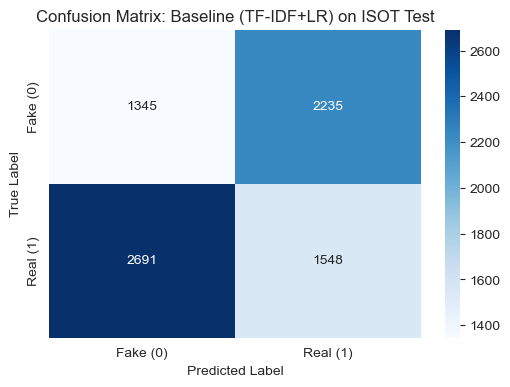

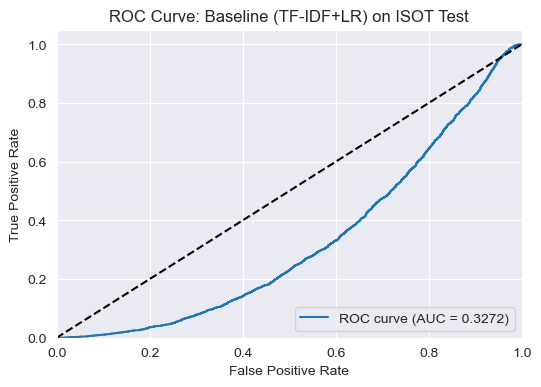


evaluating baseline on welfake test set...

evaluating Baseline (TF-IDF+LR) on WELFake Test
  accuracy:  0.6394
  precision: 0.5975
  recall:    0.6267
  f1-score:  0.6117
  roc-auc:   0.7306

  classification report:
               precision    recall  f1-score   support

           0     0.6775    0.6500    0.6635      6958
           1     0.5975    0.6267    0.6117      5767

    accuracy                         0.6394     12725
   macro avg     0.6375    0.6384    0.6376     12725
weighted avg     0.6412    0.6394    0.6400     12725



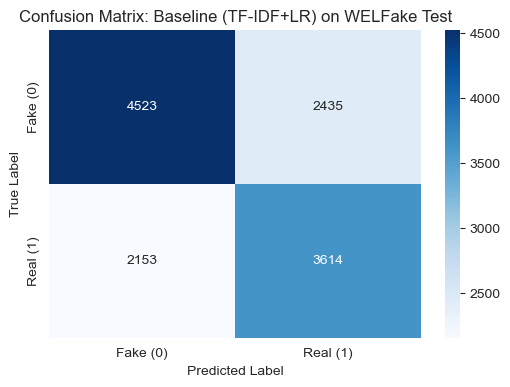

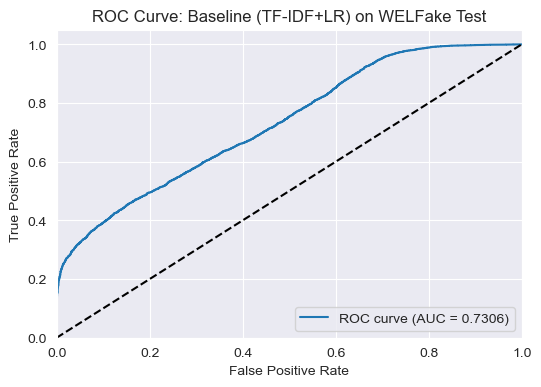


evaluating baseline on combined test set...

evaluating Baseline (TF-IDF+LR) on Combined Test
  accuracy:  0.5369
  precision: 0.5250
  recall:    0.5159
  f1-score:  0.5204
  roc-auc:   0.5961

  classification report:
               precision    recall  f1-score   support

           0     0.5478    0.5568    0.5523     10538
           1     0.5250    0.5159    0.5204     10006

    accuracy                         0.5369     20544
   macro avg     0.5364    0.5364    0.5363     20544
weighted avg     0.5367    0.5369    0.5368     20544



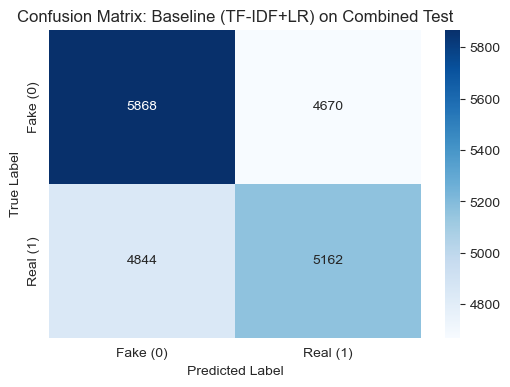

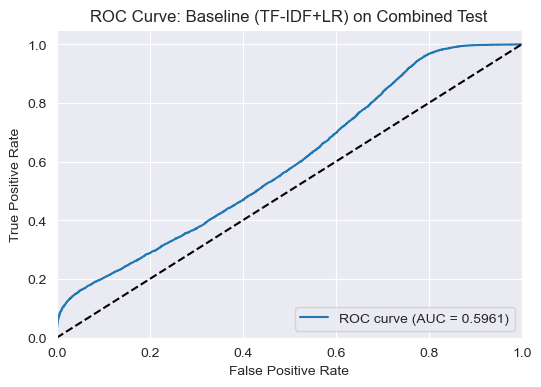


baseline model section finished.


In [27]:
print("\nbaseline model (tf-idf + logistic regression):")

# initialise dictionary to store baseline evaluation results
baseline_results_summary = {"ISOT": None, "WELFake": None, "Combined": None}
baseline_model = None # initialise model variable

# proceed only if combined training data exists
if not df_combined_train.empty:
    print("initialising tf-idf vectoriser...")
    tfidf_vectoriser = TfidfVectorizer(stop_words='english',
                                       max_features=10000, # limit features for efficiency
                                       ngram_range=(1, 2)) # include unigrams and bigrams

    # fit TF-IDF on training data, and transform all sets
    try:
        # fit vectoriser on training data only
        X_train_tfidf = tfidf_vectoriser.fit_transform(df_combined_train['cleaned_text'])
        y_train = df_combined_train['label']
        print(f"tf-idf training matrix shape: {X_train_tfidf.shape}")

        # transform test sets using the *fitted* vectoriser
        print("transforming test sets...")
        X_isot_test_tfidf = tfidf_vectoriser.transform(df_isot_test['cleaned_text']) if not df_isot_test.empty else None
        y_isot_test = df_isot_test['label'].values if not df_isot_test.empty else None # use .values for numpy array

        X_welfake_test_tfidf = tfidf_vectoriser.transform(df_welfake_test['cleaned_text']) if not df_welfake_test.empty else None
        y_welfake_test = df_welfake_test['label'].values if not df_welfake_test.empty else None # use .values

        # train logistic regression model 
        print("training logistic regression model...")
        baseline_model = LogisticRegression(solver='liblinear', # this turned out to be a good solver for this
                                           random_state=SEED,
                                           C=1.0, # regularisation strength (inverse)
                                           max_iter=1000) # i'm prepared to increase max_iter if convergence issues occur
        baseline_model.fit(X_train_tfidf, y_train)
        print("baseline model trained.")

        # evaluate baseline model on test sets
        # evaluate on isot test set
        if X_isot_test_tfidf is not None and y_isot_test is not None:
            print("\nevaluating baseline on isot test set...")
            # get predictions and probabilities
            baseline_pred_isot = baseline_model.predict(X_isot_test_tfidf)
            baseline_proba_isot = baseline_model.predict_proba(X_isot_test_tfidf)[:, 1] # prob of class 1
            # generate report and plots, store scalar metrics
            baseline_results_summary["ISOT"] = evaluate_predictions(y_isot_test, baseline_pred_isot, baseline_proba_isot,
                                                                    "Baseline (TF-IDF+LR)", "ISOT Test")
        else:
            print("\nskipping baseline evaluation on isot test: data missing.")

        # evaluate on welfake test set
        if X_welfake_test_tfidf is not None and y_welfake_test is not None:
            print("\nevaluating baseline on welfake test set...")
            # get predictions and probabilities
            baseline_pred_welfake = baseline_model.predict(X_welfake_test_tfidf)
            baseline_proba_welfake = baseline_model.predict_proba(X_welfake_test_tfidf)[:, 1] # prob of class 1
            # generate report and plots, store scalar metrics
            baseline_results_summary["WELFake"] = evaluate_predictions(y_welfake_test, baseline_pred_welfake, baseline_proba_welfake,
                                                                       "Baseline (TF-IDF+LR)", "WELFake Test")
        else:
             print("\nskipping baseline evaluation on welfake test: data missing.")

        # evaluate on combined test set
        if not df_combined_test.empty and baseline_model is not None and 'tfidf_vectoriser' in locals():
            print("\nevaluating baseline on combined test set...")
            try:
                # transform combined test set
                X_combined_test_tfidf = tfidf_vectoriser.transform(df_combined_test['cleaned_text'])
                y_combined_test = df_combined_test['label'].values

                # get predictions and probabilities
                baseline_pred_combined = baseline_model.predict(X_combined_test_tfidf)
                baseline_proba_combined = baseline_model.predict_proba(X_combined_test_tfidf)[:, 1] # prob of class 1

                # generate report and plots, store scalar metrics
                baseline_results_summary["Combined"] = evaluate_predictions(
                    y_combined_test, baseline_pred_combined, baseline_proba_combined,
                    "Baseline (TF-IDF+LR)", "Combined Test"
                )
            except Exception as e_comb_base:
                 print(f"error evaluating baseline on combined test set: {e_comb_base}")
        else:
             print("\nskipping baseline evaluation on combined test: data or model missing.")
        

    except Exception as e:
        print(f"an error occurred during baseline model processing: {e}")
        baseline_model = None # ensure model is none if an error occurs

else:
    print("skipping baseline model: combined training data is empty.")

print("\nbaseline model section finished.")

## 6. BERT & Multi-Task Learning (MTL) Setup

The following code block prepares the data and tokenizer for the DistilBERT Multi-Task Learning model:

1.  **Tokenizer Loading**: Loads the pre-trained `DistilBertTokenizer` specified in the configuration (`BERT_MODEL_NAME`). Includes error handling.

2.  **Dataset Creation**: Creates `NewsDataset` instances for the training, validation, and test splits of *both* ISOT and WELFake datasets using the `create_dataset` function and the loaded tokenizer. This step is skipped if the tokenizer failed to load.

3.  **DataLoader Creation**: Creates PyTorch `DataLoader` instances for all the created datasets using the `create_data_loader` function, setting appropriate batch sizes and shuffling behavior (shuffle=True for training loaders). This step is also skipped if the tokenizer failed to load or datasets weren't created. Checks if all necessary loaders for MTL training are available.

In [29]:
# load tokeniser
print(f"loading distilbert tokeniser: {BERT_MODEL_NAME}")
try:
    tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)
    print("tokeniser loaded successfully.")
except Exception as e:
    print(f"error loading tokeniser {BERT_MODEL_NAME}: {e}")
    # if tokenizer fails, we cannot proceed with bert models.
    tokenizer = None # set to none to prevent downstream errors

# initialise loader variables to none
isot_train_loader, isot_val_loader, isot_test_loader = None, None, None
welfake_train_loader, welfake_val_loader, welfake_test_loader = None, None, None
mtl_training_possible = False

# proceed only if tokeniser loaded successfully
if tokenizer:
    # create pytorch datasets
    # create datasets for isot
    isot_train_dataset = create_dataset(df_isot_train, tokenizer, MAX_LEN)
    isot_val_dataset = create_dataset(df_isot_val, tokenizer, MAX_LEN)
    isot_test_dataset = create_dataset(df_isot_test, tokenizer, MAX_LEN)

    # create datasets for welfake
    welfake_train_dataset = create_dataset(df_welfake_train, tokenizer, MAX_LEN)
    welfake_val_dataset = create_dataset(df_welfake_val, tokenizer, MAX_LEN)
    welfake_test_dataset = create_dataset(df_welfake_test, tokenizer, MAX_LEN)

    # create dataloaders
    print("\ncreating pytorch dataloaders...")
    num_workers = 0 # number of cpu processes for data loading (0 means main process)

    # create dataloaders for isot
    print("creating isot dataloaders...")
    isot_train_loader = create_data_loader(isot_train_dataset, BATCH_SIZE, num_workers=num_workers, shuffle=True)
    isot_val_loader = create_data_loader(isot_val_dataset, BATCH_SIZE, num_workers=num_workers, shuffle=False)
    isot_test_loader = create_data_loader(isot_test_dataset, BATCH_SIZE, num_workers=num_workers, shuffle=False)

    # create dataloaders for welfake
    print("creating welfake dataloaders...")
    welfake_train_loader = create_data_loader(welfake_train_dataset, BATCH_SIZE, num_workers=num_workers, shuffle=True)
    welfake_val_loader = create_data_loader(welfake_val_dataset, BATCH_SIZE, num_workers=num_workers, shuffle=False)
    welfake_test_loader = create_data_loader(welfake_test_dataset, BATCH_SIZE, num_workers=num_workers, shuffle=False)

    # check if essential loaders for mtl training were created successfully
    mtl_training_possible = (isot_train_loader is not None and
                             welfake_train_loader is not None and
                             isot_val_loader is not None and
                             welfake_val_loader is not None)
    if not mtl_training_possible:
         print("\nwarning: not all required dataloaders for mtl training could be created. training will be skipped.")

else:
    print("\nskipping bert dataset/dataloader creation because tokenizer failed to load.")


loading distilbert tokeniser: distilbert-base-uncased
tokeniser loaded successfully.

creating pytorch dataloaders...
creating isot dataloaders...
creating welfake dataloaders...


## 7. MTL Model Training

The following code block handles the training process for the `DistilBertMTL` model:

1.  **Initialisation**: Instantiates the `DistilBertMTL` model and moves it to the selected `device` (GPU or CPU). Skips if setup (tokenizer, loaders) failed previously.
   
2.  **Optimizer & Scheduler Setup**: Configures the `AdamW` optimizer and a linear learning rate scheduler with warmup (`get_linear_schedule_with_warmup`) based on the total number of training steps (calculated from the combined length of both training loaders and the number of epochs).

3.  **Loss Function**: Defines the `CrossEntropyLoss` function.

4.  **Training Loop**: Iterates for the specified number of `EPOCHS_MTL`. In each epoch:
    *   Calls `train_epoch_mtl` to train the model on interleaved batches from ISOT (Task A) and WELFake (Task B) training loaders.
    *   Calls `eval_model_mtl` to evaluate the model's performance on the ISOT validation set (Task A).
    *   Calls `eval_model_mtl` to evaluate the model's performance on the WELFake validation set (Task B).
    *   Calculates an average validation metric (F1-score) across both tasks.
    *   Saves the model's state dictionary (`torch.save`) to `BEST_MTL_MODEL_PATH` if the average validation metric improves compared to the best metric seen so far.
    *   Stores training and validation metrics history for plotting later.

6.  **Load Best Model**: After the training loop completes, loads the weights of the best-performing model (saved during training based on validation performance) back into the `mtl_model` instance. Includes error handling for file not found or loading issues. Sets the model to evaluation mode.

In [31]:
# initialise variables for model and training history
mtl_model = None
history_mtl = None

# dictionary to store final test results (populated in the next section)
final_mtl_results_summary = {"ISOT": None, "WELFake": None, "Combined": None}

# proceed only if setup was successful (tokeniser loaded, essential dataloaders created)
if mtl_training_possible:
    print(f"starting mtl model training for {EPOCHS_MTL} epochs.")

    # initialise model! 
    mtl_model = DistilBertMTL(bert_model_name=BERT_MODEL_NAME)
    mtl_model.to(device)

    # optimiser & scheduler
    # calculate total training steps needed for scheduler configuration
    total_steps_mtl = (len(isot_train_loader) + len(welfake_train_loader)) * EPOCHS_MTL
    optimizer_mtl = torch.optim.AdamW(mtl_model.parameters(), lr=LEARNING_RATE, eps=1e-8)
    scheduler_mtl = get_linear_schedule_with_warmup(
        optimizer_mtl,
        num_warmup_steps=0, # set number of warmup steps (e.g., 10% of total steps) if desired
        num_training_steps=total_steps_mtl
    )
    print(f"optimiser and scheduler configured for {total_steps_mtl} total steps.")

    # loss function 
    loss_fn = nn.CrossEntropyLoss().to(device)

    # training loop
    best_avg_val_f1 = 0.0 # track best average validation f1 score across tasks
    # initialise history dictionary to store metrics per epoch
    history_mtl = {'train_loss': [], 'train_acc': [],
                   'val_loss_A': [], 'val_acc_A': [], 'val_f1_A': [],
                   'val_loss_B': [], 'val_acc_B': [], 'val_f1_B': [],
                   'avg_val_f1': []}

    # loop over the specified number of epochs
    for epoch in range(EPOCHS_MTL):
        print(f'\nepoch {epoch + 1}/{EPOCHS_MTL}')
        epoch_start_time = time.time()

        # training phase for current epoch)
        # call the training function for one epoch
        try:
            train_loss, train_acc = train_epoch_mtl(
                mtl_model, isot_train_loader, welfake_train_loader, loss_fn, optimizer_mtl, device, scheduler_mtl, epoch_num=epoch + 1, total_epochs=EPOCHS_MTL
            )
        except Exception as e_call: 
            break # Stop training if the call fails

        # store training metrics
        history_mtl['train_loss'].append(train_loss)
        history_mtl['train_acc'].append(train_acc)
        print(f'  epoch {epoch + 1} training complete - avg loss: {train_loss:.4f}, avg acc: {train_acc:.4f}')

        # validation phase for current epoch. 
        print('\nvalidating mtl...')
        # evaluate on task a (isot) validation set
        val_metrics_A = eval_model_mtl(mtl_model, isot_val_loader, 'A', loss_fn, device)
        # evaluate on task b (welfake) validation set
        val_metrics_B = eval_model_mtl(mtl_model, welfake_val_loader, 'B', loss_fn, device)

        epoch_duration = time.time() - epoch_start_time

        # process and store validation results
        if val_metrics_A and val_metrics_B:
            # extract key metrics
            val_loss_A, val_acc_A, val_f1_A = val_metrics_A['loss'], val_metrics_A['accuracy'], val_metrics_A['f1']
            val_loss_B, val_acc_B, val_f1_B = val_metrics_B['loss'], val_metrics_B['accuracy'], val_metrics_B['f1']
            # calculate average f1 across tasks for model saving criterion
            avg_val_f1 = (val_f1_A + val_f1_B) / 2.0

            # store validation metrics in history
            history_mtl['val_loss_A'].append(val_loss_A); history_mtl['val_acc_A'].append(val_acc_A); history_mtl['val_f1_A'].append(val_f1_A)
            history_mtl['val_loss_B'].append(val_loss_B); history_mtl['val_acc_B'].append(val_acc_B); history_mtl['val_f1_B'].append(val_f1_B)
            history_mtl['avg_val_f1'].append(avg_val_f1)

            # print validation summary for the epoch
            print(f'isot val loss: {val_loss_A:.4f}, acc: {val_acc_A:.4f}, f1: {val_f1_A:.4f}')
            print(f'welfake val loss: {val_loss_B:.4f}, acc: {val_acc_B:.4f}, f1: {val_f1_B:.4f}')
            print(f'=> average val f1: {avg_val_f1:.4f}')

            # save best model checkpoint
            # save model if average validation f1 improves
            if avg_val_f1 > best_avg_val_f1:
                print(f"average validation f1 improved ({best_avg_val_f1:.4f} --> {avg_val_f1:.4f}). saving model checkpoint...")
                torch.save(mtl_model.state_dict(), BEST_MTL_MODEL_PATH)
                best_avg_val_f1 = avg_val_f1
            else:
                print(f"average validation f1 did not improve from {best_avg_val_f1:.4f}.")

        else:
             # handle case where validation metrics couldn't be calculated
             print("warning: could not get validation metrics for one or both tasks this epoch.")
             # append nan to history to maintain length consistency for plotting
             for key in history_mtl.keys():
                 if key not in ['train_loss', 'train_acc']: # only for validation metrics
                     history_mtl[key].append(np.nan)

        print(f'epoch {epoch + 1} time: {epoch_duration:.2f}s')


    print("\ntraining of mtl model finished. yay!")

    # load the best model weights found during training
    print(f"loading best model weights from: {BEST_MTL_MODEL_PATH}")
    try:
        # ensure model structure exists (in case loop was skipped but file exists)
        if mtl_model is None:
             mtl_model = DistilBertMTL(bert_model_name=BERT_MODEL_NAME).to(device)
        # load the saved state dictionary
        mtl_model.load_state_dict(torch.load(BEST_MTL_MODEL_PATH, map_location=device))
        print("best mtl model weights loaded successfully.")
        # set the model to evaluation mode after loading weights
        mtl_model.eval()
    except FileNotFoundError:
        print(f"warning: best model checkpoint not found at {BEST_MTL_MODEL_PATH}. using the model's state from the last epoch.")
        # ensure the model is in eval mode if training finished but file wasn't saved/found
        if mtl_model: mtl_model.eval()
    except Exception as e:
        print(f"error loading best mtl model weights: {e}. using the model's state from the last epoch.")
        # ensure the model is in eval mode
        if mtl_model: mtl_model.eval()

else:
    print("skipping mtl training: required dataloaders or tokeniser not available.")
    mtl_model = None # ensure model is none if training was skipped


starting mtl model training for 3 epochs.
optimiser and scheduler configured for 13485 total steps.

epoch 1/3


Epoch 1/3 Training: 100%|█████████████████████████████████| 4495/4495 [21:33<00:00,  3.47it/s, acc=0.9826, loss=0.0538]



  epoch 1 training complete - avg loss: 0.0538, avg acc: 0.9826

validating mtl...
isot val loss: 0.0037, acc: 0.9992, f1: 0.9993
welfake val loss: 0.0480, acc: 0.9874, f1: 0.9861
=> average val f1: 0.9927
average validation f1 improved (0.0000 --> 0.9927). saving model checkpoint...
epoch 1 time: 1433.64s

epoch 2/3


Epoch 2/3 Training: 100%|█████████████████████████████████| 4495/4495 [21:47<00:00,  3.44it/s, acc=0.9959, loss=0.0158]



  epoch 2 training complete - avg loss: 0.0158, avg acc: 0.9959

validating mtl...
isot val loss: 0.0045, acc: 0.9992, f1: 0.9993
welfake val loss: 0.0570, acc: 0.9874, f1: 0.9860
=> average val f1: 0.9926
average validation f1 did not improve from 0.9927.
epoch 2 time: 1443.58s

epoch 3/3


Epoch 3/3 Training: 100%|█████████████████████████████████| 4495/4495 [21:42<00:00,  3.45it/s, acc=0.9988, loss=0.0047]



  epoch 3 training complete - avg loss: 0.0047, avg acc: 0.9988

validating mtl...
isot val loss: 0.0054, acc: 0.9992, f1: 0.9993
welfake val loss: 0.0600, acc: 0.9892, f1: 0.9880
=> average val f1: 0.9937
average validation f1 improved (0.9927 --> 0.9937). saving model checkpoint...
epoch 3 time: 1441.63s

training of mtl model finished. yay!
loading best model weights from: ./model_checkpoints_mtl\mtl_model_best.bin
best mtl model weights loaded successfully.


## 8. MTL Model Evaluation

The following code block evaluates the final trained (or best loaded) `DistilBertMTL` model on the held-out test sets:

1.  **Evaluate on ISOT Test Set**: Calls `eval_model_mtl` with the ISOT test loader (`isot_test_loader`) and `task_id='A'`. This returns a dictionary including metrics, predictions, and probabilities. Skips if the model or loader is unavailable.

2.  **Report ISOT Test Results**: If evaluation was successful, it calls `evaluate_predictions` using the true labels, predicted labels, and probabilities from the previous step to print metrics and display plots (Confusion Matrix, ROC Curve) specifically for the MTL model's performance on the ISOT test data. The scalar metrics are stored.

3.  **Evaluate on WELFake Test Set**: Calls `eval_model_mtl` with the WELFake test loader (`welfake_test_loader`) and `task_id='B'`. Skips if the model or loader is unavailable.

4.  **Report WELFake Test Results**: If evaluation was successful, it calls `evaluate_predictions` using the results from the WELFake evaluation to report metrics and plots for the MTL model on the WELFake test data. The scalar metrics are stored.

5.  **Plot Training History**: If training was performed (`history_mtl` exists), it plots the training and validation loss, accuracy, and F1 scores over epochs.


evaluating final mtl model on test sets.

evaluating mtl on isot test set (task a)...

evaluating MTL Model on ISOT Test
  accuracy:  1.0000
  precision: 1.0000
  recall:    1.0000
  f1-score:  1.0000
  roc-auc:   1.0000

  classification report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3580
           1     1.0000    1.0000    1.0000      4239

    accuracy                         1.0000      7819
   macro avg     1.0000    1.0000    1.0000      7819
weighted avg     1.0000    1.0000    1.0000      7819



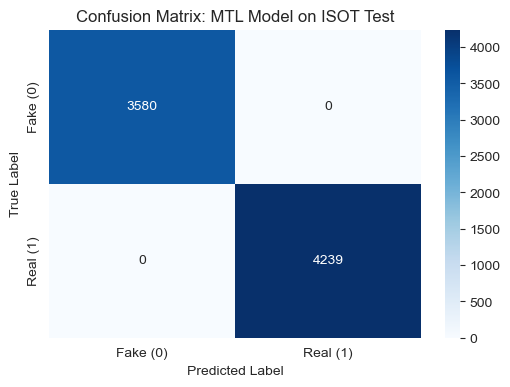

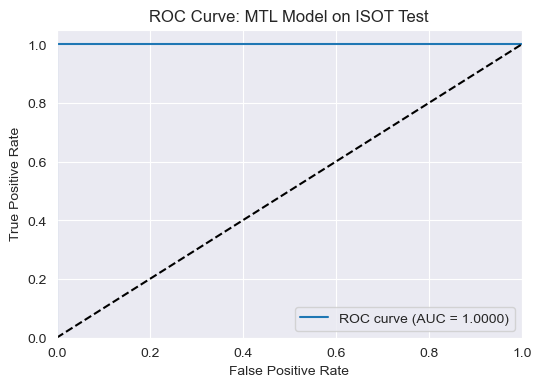

mtl evaluation on isot test complete.

evaluating mtl on welfake test set (task b)...

evaluating MTL Model on WELFake Test
  accuracy:  0.9913
  precision: 0.9896
  recall:    0.9912
  f1-score:  0.9904
  roc-auc:   0.9993

  classification report:
               precision    recall  f1-score   support

           0     0.9927    0.9914    0.9920      6958
           1     0.9896    0.9912    0.9904      5767

    accuracy                         0.9913     12725
   macro avg     0.9911    0.9913    0.9912     12725
weighted avg     0.9913    0.9913    0.9913     12725



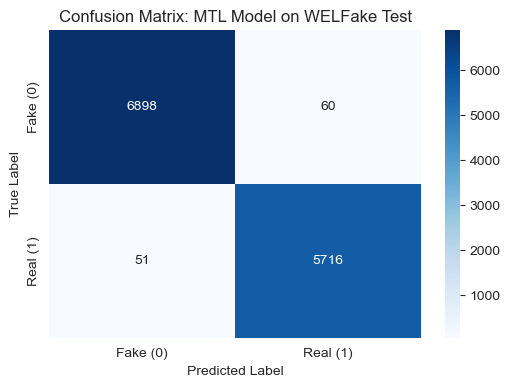

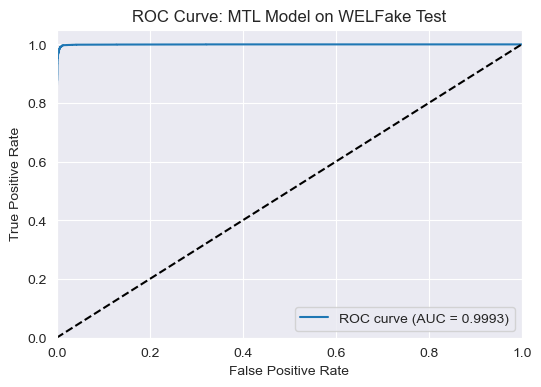

mtl evaluation on welfake test complete.

calculating mtl performance on combined test set...
combined test shapes: true=(20544,), pred=(20544,), proba=(20544,)

evaluating MTL Model on Combined Test
  accuracy:  0.9946
  precision: 0.9940
  recall:    0.9949
  f1-score:  0.9945
  roc-auc:   0.9997

  classification report:
               precision    recall  f1-score   support

           0     0.9952    0.9943    0.9947     10538
           1     0.9940    0.9949    0.9945     10006

    accuracy                         0.9946     20544
   macro avg     0.9946    0.9946    0.9946     20544
weighted avg     0.9946    0.9946    0.9946     20544



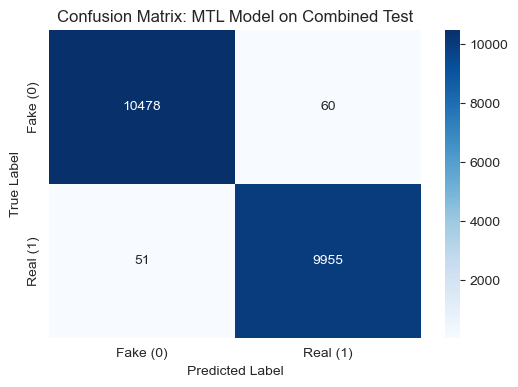

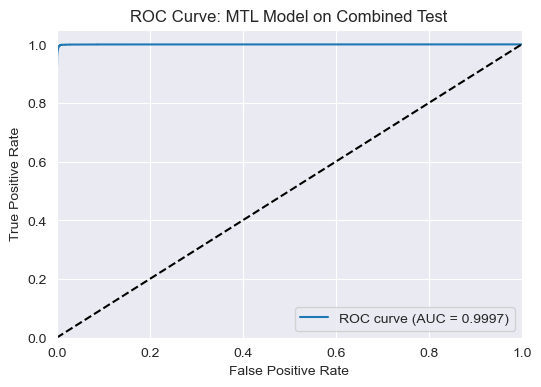

mtl evaluation on combined test complete.

mtl model evaluation section finished.

plotting training history


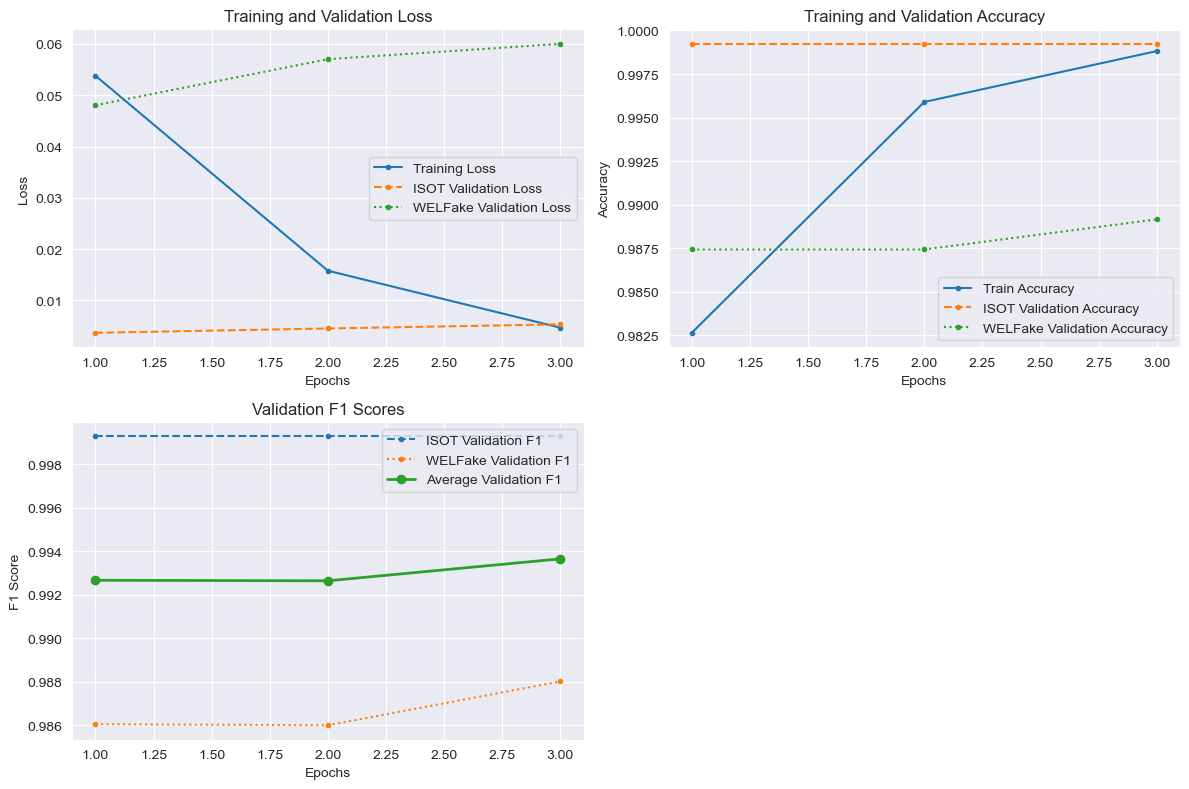

In [33]:
print("\nevaluating final mtl model on test sets.")

# variables to store raw evaluation results
y_true_isot_test, y_pred_isot_test, y_proba_isot_test = None, None, None
y_true_welfake_test, y_pred_welfake_test, y_proba_welfake_test = None, None, None


# proceed only if the mtl model was trained/loaded successfully and loss_fn exists
if mtl_model is not None and 'loss_fn' in locals() and loss_fn is not None:

    # evaluate on ISOT test set (Task A)
    if isot_test_loader:
        print("\nevaluating mtl on isot test set (task a)...")
        # get full evaluation metrics including predictions/probabilities for detailed reporting
        eval_results_isot_test = eval_model_mtl(
            mtl_model, isot_test_loader, 'A', loss_fn, device
        )

        if eval_results_isot_test:
             # store raw results as numpy arrays 
             y_true_isot_test = np.array(eval_results_isot_test['true_labels'])
             y_pred_isot_test = np.array(eval_results_isot_test['predictions'])
             y_proba_isot_test = np.array(eval_results_isot_test['probabilities'])

             # generate summary report and plots using evaluate_predictions
             # store the returned scalar metrics
             final_mtl_results_summary["ISOT"] = evaluate_predictions(
                 y_true_isot_test, y_pred_isot_test, y_proba_isot_test, # Use stored arrays
                 "MTL Model", "ISOT Test"
             )
             if final_mtl_results_summary["ISOT"]:
                 print("mtl evaluation on isot test complete.")
             else:
                 print("error generating final report for mtl on isot test.")
        else:
             print("evaluation failed for mtl on isot test (eval_model_mtl returned none).")
    else:
        print("skipping mtl evaluation on isot test: loader missing.")


    # evaluate on WELFake test set (Task B) 
    if welfake_test_loader:
        print("\nevaluating mtl on welfake test set (task b)...")
        # get full evaluation metrics
        eval_results_welfake_test = eval_model_mtl(
            mtl_model, welfake_test_loader, 'B', loss_fn, device
        )

        if eval_results_welfake_test:
            # store raw results as numpy arrays 
            y_true_welfake_test = np.array(eval_results_welfake_test['true_labels'])
            y_pred_welfake_test = np.array(eval_results_welfake_test['predictions'])
            y_proba_welfake_test = np.array(eval_results_welfake_test['probabilities'])

            # generate summary report and plots, store scalar metrics
            final_mtl_results_summary["WELFake"] = evaluate_predictions(
                y_true_welfake_test, y_pred_welfake_test, y_proba_welfake_test, # Use stored arrays
                "MTL Model", "WELFake Test"
            )
            if final_mtl_results_summary["WELFake"]:
                 print("mtl evaluation on welfake test complete.")
            else:
                 print("error generating final report for mtl on welfake test.")
        else:
             print("evaluation failed for mtl on welfake test (eval_model_mtl returned none).")
    else:
        print("skipping mtl evaluation on welfake test: loader missing.")

    # evaluate on combined test set (using concatenated results)
    print("\ncalculating mtl performance on combined test set...")
    # check if results from both individual evaluations are available
    if y_true_isot_test is not None and y_true_welfake_test is not None:
        # ensure all parts (true, pred, proba) are available for both
        if y_pred_isot_test is not None and y_proba_isot_test is not None and \
           y_pred_welfake_test is not None and y_proba_welfake_test is not None:

            try: # try-except for concatenation
                y_true_combined = np.concatenate((y_true_isot_test, y_true_welfake_test))
                y_pred_combined = np.concatenate((y_pred_isot_test, y_pred_welfake_test))
                y_proba_combined = np.concatenate((y_proba_isot_test, y_proba_welfake_test))

                print(f"combined test shapes: true={y_true_combined.shape}, pred={y_pred_combined.shape}, proba={y_proba_combined.shape}")

                # generate summary report and plots, store scalar metrics
                final_mtl_results_summary["Combined"] = evaluate_predictions(
                    y_true_combined, y_pred_combined, y_proba_combined,
                    "MTL Model", "Combined Test"
                )
                if final_mtl_results_summary["Combined"]:
                     print("mtl evaluation on combined test complete.")
                else:
                     print("error generating final report for mtl on combined test.")
            except ValueError as e_concat:
                 print(f"error concatenating results for combined mtl evaluation: {e_concat}")
                 print("check shapes of individual result arrays:")
                 print(f"  isot: true={y_true_isot_test.shape}, pred={y_pred_isot_test.shape}, proba={y_proba_isot_test.shape}")
                 print(f"  welfake: true={y_true_welfake_test.shape}, pred={y_pred_welfake_test.shape}, proba={y_proba_welfake_test.shape}")

        else:
             print("skipping mtl combined evaluation: missing prediction/probability arrays from individual tasks.")
    else:
        print("skipping mtl combined evaluation: missing true label arrays from individual tasks.")

else:
    print("skipping mtl evaluation: model was not trained or loaded successfully, or loss_fn is missing.")

print("\nmtl model evaluation section finished.") # Added print

# plot training history
# plot if training was performed and history was recorded
if history_mtl:
    print("\nplotting training history")
    try:
        # use actual length in case training stopped early or had issues
        epochs_with_data = len(history_mtl['train_loss'])
        if epochs_with_data == 0:
             print("no training data recorded in history.")
        else:
            epochs_range = range(1, epochs_with_data + 1)
            plt.figure(figsize=(12, 8))

            # check if validation keys have data before plotting
            val_epochs_with_data = len(history_mtl.get('avg_val_f1', []))

            # subplot 1: Loss
            plt.subplot(2, 2, 1)
            plt.plot(epochs_range, history_mtl['train_loss'][:epochs_with_data], label='Training Loss', marker='.')
            if 'val_loss_A' in history_mtl and len(history_mtl['val_loss_A']) >= epochs_with_data:
                 plt.plot(epochs_range, history_mtl['val_loss_A'][:epochs_with_data], label='ISOT Validation Loss', linestyle='--', marker='.')
            if 'val_loss_B' in history_mtl and len(history_mtl['val_loss_B']) >= epochs_with_data:
                 plt.plot(epochs_range, history_mtl['val_loss_B'][:epochs_with_data], label='WELFake Validation Loss', linestyle=':', marker='.')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # subplot 2: accuracy
            plt.subplot(2, 2, 2)
            plt.plot(epochs_range, history_mtl['train_acc'][:epochs_with_data], label='Train Accuracy', marker='.')
            if 'val_acc_A' in history_mtl and len(history_mtl['val_acc_A']) >= epochs_with_data:
                 plt.plot(epochs_range, history_mtl['val_acc_A'][:epochs_with_data], label='ISOT Validation Accuracy', linestyle='--', marker='.')
            if 'val_acc_B' in history_mtl and len(history_mtl['val_acc_B']) >= epochs_with_data:
                 plt.plot(epochs_range, history_mtl['val_acc_B'][:epochs_with_data], label='WELFake Validation Accuracy', linestyle=':', marker='.')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # subplot 3: F1 score
            plt.subplot(2, 2, 3)
            if 'val_f1_A' in history_mtl and len(history_mtl['val_f1_A']) >= epochs_with_data:
                 plt.plot(epochs_range, history_mtl['val_f1_A'][:epochs_with_data], label='ISOT Validation F1', linestyle='--', marker='.')
            if 'val_f1_B' in history_mtl and len(history_mtl['val_f1_B']) >= epochs_with_data:
                 plt.plot(epochs_range, history_mtl['val_f1_B'][:epochs_with_data], label='WELFake Validation F1', linestyle=':', marker='.')
            if 'avg_val_f1' in history_mtl and len(history_mtl['avg_val_f1']) >= epochs_with_data:
                 plt.plot(epochs_range, history_mtl['avg_val_f1'][:epochs_with_data], label='Average Validation F1', linestyle='-', marker='o', linewidth=2)
            plt.title('Validation F1 Scores')
            plt.xlabel('Epochs')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.grid(True)

            # adjust layout to prevent overlapping titles/labels
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"could not plot training history: {e}")
        # this might happen if training was interrupted or history keys have inconsistent lengths or NaN values.
else:
    print("\nno training history available to plot.")

## 9. Results Summary

The following code block aggregates the final evaluation metrics (Accuracy, Precision, Recall, F1, ROC AUC) from both the Baseline model and the MTL model for both test sets (ISOT and WELFake) into a single Pandas DataFrame for easy comparison. The DataFrame is then sorted and printed. Optionally, the summary table can be saved to a CSV file.

In [35]:
print("\nfinal performance summary:")

# aggregate results into a list of dictionaries
results_list = []

# add baseline results (checking if they were successfully computed)
if baseline_results_summary.get("ISOT"): # use .get() for safer access
    results_list.append({
        'Dataset': 'ISOT Test',
        'Model': 'Baseline (TF-IDF+LR)',
        **baseline_results_summary["ISOT"] # unpack the metrics dict
    })
if baseline_results_summary.get("WELFake"):
    results_list.append({
        'Dataset': 'WELFake Test',
        'Model': 'Baseline (TF-IDF+LR)',
        **baseline_results_summary["WELFake"]
    })
if baseline_results_summary.get("Combined"):
    results_list.append({
        'Dataset': 'Combined Test', 'Model': 'Baseline (TF-IDF+LR)', **baseline_results_summary["Combined"]
    })

# add mtl results (checking if they were successfully computed)
if final_mtl_results_summary.get("ISOT"):
    results_list.append({
        'Dataset': 'ISOT Test',
        'Model': 'MTL-BERT',
        **final_mtl_results_summary["ISOT"]
    })
if final_mtl_results_summary.get("WELFake"):
    results_list.append({
        'Dataset': 'WELFake Test',
        'Model': 'MTL-BERT',
        **final_mtl_results_summary["WELFake"]
    })
if final_mtl_results_summary.get("Combined"):
    results_list.append({
        'Dataset': 'Combined Test', 'Model': 'MTL-BERT', **final_mtl_results_summary["Combined"]
    })

# create and display dataframe.
if results_list:
    # create dataframe from the list of results
    df_results_final = pd.DataFrame(results_list)

    # define columns to display and their desired order
    display_cols = ['Dataset', 'Model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    # ensure only available columns are selected (in case some metric calculation failed)
    available_cols = [col for col in display_cols if col in df_results_final.columns]

    # sort the dataframe for consistent presentation
    df_results_sorted = df_results_final.sort_values(by=['Dataset', 'Model']).reset_index(drop=True)

    print("\ncomparison of model performance on test sets:")
    display(df_results_sorted[available_cols])

    # save the results table to a csv file (or i'll comment this out to not, but feels like i'll need for report)
    results_csv_path = os.path.join(RESULTS_DIR, 'final_results_summary.csv')
    try:
        df_results_sorted[available_cols].to_csv(results_csv_path, index=False, float_format='%.4f') # keep float format for CSV
        print(f"\nresults summary saved to: {results_csv_path}")
    except Exception as e:
        print(f"\nerror saving results summary to csv: {e}")

else:
     print("no evaluation results available to display.")


final performance summary:

comparison of model performance on test sets:


,Dataset,Model,accuracy,precision,recall,f1,roc_auc
0,Combined Test,Baseline (TF-IDF+LR),0.536896,0.525020,0.515890,0.520415,0.596141
1,Combined Test,MTL-BERT,0.994597,0.994009,0.994903,0.994456,0.999666
2,ISOT Test,Baseline (TF-IDF+LR),0.369996,0.409199,0.365180,0.385939,0.327151
3,ISOT Test,MTL-BERT,1.000000,1.000000,1.000000,1.000000,1.000000
4,WELFake Test,Baseline (TF-IDF+LR),0.639450,0.597454,0.626669,0.611713,0.730618
5,WELFake Test,MTL-BERT,0.991277,0.989612,0.991157,0.990384,0.999267



results summary saved to: ./results\final_results_summary.csv


## 10. Interactive GUI for Prediction and Explanation (Domain-Specific + LIME)

The following code block sets up and launches an interactive Gradio web interface. This GUI incorporates the domain classification strategy and LIME explanations.

1.  **Domain Prediction**: It uses the trained `domain_classifier` to predict the source domain (ISOT/WELFake) of the input text.

2.  **Specialized Head Selection**: It selects the appropriate MTL head (A or B) based on the predicted domain.

3.  **Final Classification**: It performs Fake/Real classification using the selected head.
    
4.  **LIME Explanation**: It generates a LIME explanation, highlighting words that contributed to the prediction made by the *selected* head.

5.  **Interface**: It uses `gradio` to display the input text box, the final prediction, confidence, text explanation (including domain info), and the LIME visualization.

In [127]:
# Interactive GUI (Application Layer)

# this function serves as the predictor required by LIME. it takes a list of
# perturbed text samples generated by LIME and returns the model's prediction
# probabilities (for fake/real) for each sample using a specific MTL head.
# arguments:
#   texts - list of text strings (original and perturbed) from LIME
#   model - the pytorch mtl model object
#   tokenizer - the bert tokenizer instance
#   device - the device to run inference on ('cuda' or 'cpu')
#   max_len - maximum sequence length for tokenization
#   task_id_for_lime - the specific mtl head ('A' or 'B') to use for predictions
# returns:
#   numpy array of shape (num_samples, 2) with probabilities for [fake, real]
def lime_predictor_for_mtl(texts, model, tokenizer, device, max_len, task_id_for_lime):
    # step 1: set model to evaluation mode and move to device
    model.eval()
    model.to(device)
    all_probabilities = []

    # step 2: iterate through text samples provided by LIME
    for text in texts:
        # step 2a: handle potentially empty/invalid samples from LIME perturbations
        if not isinstance(text, str) or not text.strip():
            all_probabilities.append(np.array([0.5, 0.5])) # return neutral probability
            continue
        # step 2b: process valid text samples
        try:
            # tokenize the text sample
            enc = tokenizer.encode_plus(
                text, add_special_tokens=True, max_length=max_len,
                padding='max_length', truncation=True, return_attention_mask=True,
                return_tensors='pt',
            )
            ids = enc['input_ids'].to(device)
            mask = enc['attention_mask'].to(device)

            # perform inference without calculating gradients
            with torch.no_grad():
                # forward pass using the *specified* task_id for this LIME run
                lgts = model(input_ids=ids, attention_mask=mask, task_id=task_id_for_lime)

            # apply softmax to get probabilities and move to cpu
            prbs = F.softmax(lgts, dim=1).cpu().numpy()[0]
            all_probabilities.append(prbs)
        except Exception as e_inner_pred:
            # handle errors during tokenization or prediction for a specific sample
            print(f"[LIME Predictor] error processing text: '{text[:50]}...' -> {e_inner_pred}")
            all_probabilities.append(np.array([0.5, 0.5])) # return neutral on error

    # step 3: convert list of probabilities to numpy array
    final_probs = np.array(all_probabilities)

    # step 4: validate and potentially correct the output shape for LIME
    # LIME expects shape (num_samples, num_classes), e.g., (N, 2)
    if final_probs.ndim == 1 and len(texts) == 1 and final_probs.shape[0] == 2:
        final_probs = final_probs.reshape(1, 2) # correct shape for single sample case
    elif final_probs.ndim != 2 or final_probs.shape[1] != 2:
         # if shape is incorrect (e.g., flattened or wrong class count), log warning and return neutral
         print(f"[LIME Predictor] warning: correcting output shape. original: {final_probs.shape}, num texts: {len(texts)}")
         final_probs = np.full((len(texts), 2), 0.5)

    # print(f"[LIME Predictor] Returning probabilities shape: {final_probs.shape}") # debug print
    return final_probs



# this function orchestrates the prediction process: cleaning, domain prediction,
# mtl prediction using the selected head, and LIME explanation generation.
# it is called by the gradio_interface_fn wrapper.
# arguments:
#   raw_text - the raw input text string from the user
#   mtl_model_obj - the trained pytorch mtl model object
#   bert_tokenizer - the loaded bert tokenizer instance
#   clean_fn - the text cleaning function (e.g., clean_text)
#   max_len_val - the maximum sequence length for bert tokenization
#   dev - the device ('cuda' or 'cpu')
#   domain_clf - the trained domain classifier (e.g., logistic regression)
#   domain_vec - the fitted domain tf-idf vectorizer
#   num_features_lime - number of features for LIME explanation
#   num_samples_lime - number of samples for LIME perturbation
# returns:
#   list containing [prediction, confidence, text_explanation, details, lime_html_output]
def predict_domain_then_classify_logic(raw_text,
                                       mtl_model_obj, bert_tokenizer, clean_fn, max_len_val, dev,
                                       domain_clf, domain_vec,
                                       num_features_lime=10, num_samples_lime=500):

    # step 1: initialize output list with default error values
    outputs = ["Error"] * 5 # prediction, confidence, explanation, details, lime_html
    outputs[4] = "<p style='color:red;'>LIME: Not Started.</p>" # initial LIME html state

    try:
        # step 2: basic checks for required components
        if mtl_model_obj is None or bert_tokenizer is None or clean_fn is None or \
           domain_clf is None or domain_vec is None:
            outputs[2] = "error: one or more required backend components missing."
            print(outputs[2])
            outputs[4] = "<p style='color:red;'>LIME Skipped: required component missing.</p>"
            return outputs

        # step 3: clean the input text
        cleaned = clean_fn(raw_text)
        # step 3a: handle case where cleaning results in empty text
        if not cleaned.strip():
            outputs[2] = "error: Cleaned text is empty or whitespace only."
            print(outputs[2])
            outputs[4] = "<p style='color:orange;'>LIME skipped: input text is empty after cleaning.</p>"
            return outputs

        # step 4: predict the domain (ISOT or WELFake)
        predicted_domain_name = "Unknown"
        selected_task_id = None
        domain_pred_proba = [0.0, 0.0]
        domain_confidence = 0.0
        try:
            # step 4a: vectorize cleaned text using domain vectorizer
            text_tfidf_domain = domain_vec.transform([cleaned])
            # step 4b: get domain prediction probabilities
            domain_pred_proba = domain_clf.predict_proba(text_tfidf_domain)[0] # [P_ISOT, P_WELFake]
            # step 4c: determine predicted domain label and confidence
            predicted_domain_label = np.argmax(domain_pred_proba)
            domain_confidence = np.max(domain_pred_proba)
            # step 4d: map label to task_id ('A' or 'B') and name
            selected_task_id = 'A' if predicted_domain_label == 0 else 'B'
            predicted_domain_name = "ISOT" if selected_task_id == 'A' else "WELFake"
        except Exception as e_domain_pred:
            # handle errors during domain prediction
            outputs[2] = f"error during domain prediction: {e_domain_pred}"
            print(outputs[2])
            outputs[4] = f"<p style='color:red;'>LIME skipped due to domain prediction error: {e_domain_pred}</p>"
            return outputs # return early if domain prediction fails

        # step 5: get fake/real prediction from the selected MTL head
        prediction_final = "Error"
        confidence_final_str = "0.00%"
        logits = None
        probs = np.array([0.5, 0.5]) # default probabilities
        try:
            # step 5a: set model to evaluation mode and move to device
            mtl_model_obj = mtl_model_obj.to(dev)
            mtl_model_obj.eval()
            # step 5b: tokenize cleaned text for BERT
            encoding = bert_tokenizer.encode_plus(
                cleaned, add_special_tokens=True, max_length=max_len_val,
                padding='max_length', truncation=True, return_attention_mask=True,
                return_tensors='pt',
            )
            input_ids = encoding['input_ids'].to(dev)
            attention_mask = encoding['attention_mask'].to(dev)
            # step 5c: forward pass through MTL model using selected head
            with torch.no_grad():
                logits = mtl_model_obj(input_ids=input_ids, attention_mask=attention_mask, task_id=selected_task_id)
            # step 5d: calculate probabilities
            probs = F.softmax(logits, dim=1).cpu().numpy()[0] # [P_fake, P_real]
            fake_prob, real_prob = probs[0], probs[1]
            # step 5e: determine final prediction and confidence
            prediction_final = "REAL" if real_prob >= fake_prob else "FAKE"
            confidence_final = real_prob if prediction_final == "REAL" else fake_prob
            confidence_final_str = f"{confidence_final:.2%}"
        except Exception as e_mtl_pred:
             # handle errors during MTL prediction
             outputs[2] = f"error during MTL prediction (Head {selected_task_id}): {e_mtl_pred}"
             print(outputs[2])
             outputs[4] = f"<p style='color:red;'>LIME skipped due to MTL prediction error: {e_mtl_pred}</p>"
             return outputs # return early if MTL prediction fails

        # LIME explanation generation 
        lime_html = "<p style='color:red;'>LIME: failed inside try block.</p>" # default error message
        try:
            # step 6a: create a partial function for the LIME predictor, fixing the
            # arguments needed by lime_predictor_for_mtl for this specific run
            lime_predictor_partial = functools.partial(
                lime_predictor_for_mtl, # use the external function defined above
                model=mtl_model_obj,
                tokenizer=bert_tokenizer,
                device=dev,
                max_len=max_len_val,
                task_id_for_lime=selected_task_id # Pass the dynamically selected task ID
            )

            # step 6b: instantiate the LIME text explainer
            explainer = lime.lime_text.LimeTextExplainer(class_names=["FAKE", "REAL"])

            # step 6c: generate the explanation object from LIME
            explanation_lime = explainer.explain_instance(
                cleaned,                 # the text instance to explain
                lime_predictor_partial,  # the prediction function (with fixed args)
                num_features=num_features_lime, # how many words to show
                num_samples=num_samples_lime    # number of perturbations for LIME
            )

            # step 6d: format the LIME explanation as HTML (using iframe for large content)
            if explanation_lime:
                lime_html_content = explanation_lime.as_html()
                # check if the generated html is very short (might indicate an issue)
                if len(lime_html_content) < 100:
                     lime_html = "<p style='color:orange;'>LIME: explanation returned empty or very short.</p>"
                else:
                    # format using iframe and base64 encoding to handle potentially large HTML
                    try:
                        import base64
                        html_bytes = lime_html_content.encode('utf-8')
                        html_base64 = base64.b64encode(html_bytes).decode('utf-8')
                        iframe_src = f"data:text/html;base64,{html_base64}"
                        lime_html = f"""
                        <div style='border: 1px solid #CCC; padding: 10px; border-radius: 5px; background-color: white;'>
                            <p style='color: black;'><strong>LIME Explanation (influential words for '{prediction_final}' prediction by Head {selected_task_id}):</strong></p>
                            <iframe src="{iframe_src}" width="100%" height="450px" style="border:none;"></iframe>
                        </div>
                        """
                    except Exception as e_iframe:
                         # handle error during iframe formatting
                         print(f"[Prediction Logic] error creating iframe data URI: {e_iframe}")
                         lime_html = f"<p style='color:red;'>LIME: Error formatting HTML for display.<br>{e_iframe}</p>"
            else:
                # handle case where LIME returns no explanation
                print("warning:: LIME explain_instance returned None or empty.")
                lime_html = "<p style='color:orange;'>LIME: explanation returned empty.</p>"

        except Exception as e_lime:
             # handle any unexpected error during the LIME generation process
             print(f"[Prediction Logic] LIME error details: {e_lime}")
             traceback.print_exc() # print full traceback to console for debugging
             lime_html = f"<p style='color:red;'><strong>LIME error (exception caught):</strong><br>{e_lime}</p>"


        # step 7: prepare final output strings for Gradio
        # step 7a: generate the combined text explanation
        explanation_text = (
            f"The text's writing style seems most similar to the **{predicted_domain_name}** dataset.\n\n"
            f"Based on this style, the model predicts the news is **{prediction_final}** with **{confidence_final_str}** confidence.\n\n"
            f"See the LIME explanation below for words influencing this '{prediction_final}' decision."
        )

        # step 7b: generate the detailed technical output string
        details_text = (
            f"Predicted Fake Probability: {probs[0]:.1%}\n"
            f"Predicted Real Probability: {probs[1]:.1%}\n"
            f"(Analysis based on {predicted_domain_name} style)"
        )

        # step 7c: assign all results to the output list
        outputs = [
            prediction_final,
            confidence_final_str,
            explanation_text,
            details_text,
            lime_html # the generated LIME html (or error message)
        ]
        return outputs # return the list of outputs

    except Exception as e_outer:
        # handle any top-level unexpected errors in the main function
        error_msg_outer = f"An outer error occurred: {e_outer}"
        print(f"\n**** [Prediction Logic] TOP LEVEL UNCAUGHT ERROR: {e_outer} ****")
        traceback.print_exc() # print traceback for debugging
        outputs[2] = error_msg_outer
        # provide context in LIME error message if possible
        lime_err_detail = f"task_id={selected_task_id}" if selected_task_id else "selected_task_id might be undefined"
        outputs[4] = f"<p style='color:red;'>LIME Skipped due to outer error ({lime_err_detail}):<br>{e_outer}</p>"
        return outputs



# this function acts as an intermediary between gradio and the main prediction logic.
# it takes the raw text input from gradio and calls the logic function, passing
# along the necessary model components captured from the notebook's global scope.
# arguments:
#   raw_text_input - the text string entered by the user in the gradio interface
# returns:
#   list of outputs expected by the gradio interface
def gradio_interface_fn(raw_text_input):
    # step 1: check if all required global objects are loaded and available
    if 'mtl_model' in globals() and 'tokenizer' in globals() and \
       'clean_text' in globals() and 'MAX_LEN' in globals() and \
       'device' in globals() and 'domain_classifier' in globals() and \
       'domain_vectorizer' in globals() and \
        mtl_model is not None and tokenizer is not None and \
        callable(clean_text) and device is not None and \
        domain_classifier is not None and domain_vectorizer is not None:

        # step 2: if objects are available, call the main prediction logic function
        return predict_domain_then_classify_logic(
            raw_text=raw_text_input,
            mtl_model_obj=mtl_model,       # pass the globally loaded model
            bert_tokenizer=tokenizer,    # pass the globally loaded tokenizer
            clean_fn=clean_text,         # pass the cleaning function
            max_len_val=MAX_LEN,         # pass max sequence length
            dev=device,                  # pass the device
            domain_clf=domain_classifier,# pass the domain classifier
            domain_vec=domain_vectorizer,# pass the domain vectorizer
            num_samples_lime=500          # set LIME samples (can be adjusted)
        )
    else:
        # step 3: if objects are missing, return an error state to gradio
        error_msg = "error: Backend components (model, tokenizer, etc.) not loaded properly."
        print(f"[gradio_interface_fn] {error_msg}")
        return ["Error", "N/A", error_msg, "N/A", "<p style='color:red;'>LIME error: backend components missing.</p>"]


# create & launch gradio interface
all_objects_ok = True
# step 1: verify all necessary global variables/objects exist
if 'mtl_model' not in globals() or mtl_model is None: all_objects_ok = False; print("error: mtl_model not found or is None.")
if 'tokenizer' not in globals() or tokenizer is None: all_objects_ok = False; print("error: tokenizer not found or is None.")
if 'device' not in globals() or device is None: all_objects_ok = False; print("error: device not found or is None.")
if 'clean_text' not in globals() or not callable(clean_text): all_objects_ok = False; print("error: clean_text function not found or not callable.")
if 'MAX_LEN' not in globals() or not isinstance(MAX_LEN, int): all_objects_ok = False; print("error: MAX_LEN not found or not an integer.")
if 'domain_classifier' not in globals() or domain_classifier is None: all_objects_ok = False; print("error: domain_classifier not found or is None.")
if 'domain_vectorizer' not in globals() or domain_vectorizer is None: all_objects_ok = False; print("error: domain_vectorizer not found or is None.")

# step 2: proceed only if all checks passed
if all_objects_ok:
    # step 3: create the gradio interface instance
        iface = gr.Interface(
        fn=gradio_interface_fn, # Use the wrapper function
        inputs=gr.Textbox(lines=10, label="Enter Text to Classify:"), # Simplified label
        # define output components with updated labels
        outputs=[
            gr.Textbox(label="Prediction"), # Simplified
            gr.Textbox(label="Confidence"), # Simplified
            gr.Textbox(label="Explanation"), # Simplified
            gr.Textbox(label="Prediction Probabilities"), # Changed label
            gr.HTML(label="Word Importance (LIME)") # Simplified LIME label
        ],
        title="Fake News Detector (MTL-BERT + LIME)",
        description="Enter news text below. The model analyzes the writing style, predicts if it's Fake or Real using a specialized analyzer, and shows which words influenced the decision.", # More user-friendly description
        flagging_mode=None
    )
    
    # step 4: launch the interface (add debug=True for more console output from gradio)
        iface.launch(share=False, debug=True)
else:
    # step 5: inform user if launch is skipped due to missing components
    print("\nSkipping gradio launch due to missing required global objects.")
    print("please ensure model, tokenizer, domain classifier/vectorizer etc. are loaded and available.")

IndentationError: unindent does not match any outer indentation level (<string>, line 332)